In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [12]:
# --- 1. 데이터 로드 및 준비 ---
# 전처리 완료된 데이터 삽입
df = pd.read_csv('output_data.csv')


# --- 2. Prefix 정의 및 칼럼 그룹핑 ---
# 이미지에 나온 prefix들을 리스트로 정의합니다.
# 'M'은 타겟이므로 제외합니다.
prefixes = [
    'TC_', 'AC_', 'WC_', 'PA_', 'F_', 'I_', 'V_', 'S_', 'O_',
    'HW_', 'AS_', 'RH_', 'ECZ_', 'INT_', 'DR_', 'E_'
]

# 타겟 칼럼(M으로 시작)과 피처 칼럼을 분리합니다.
m_targets = [col for col in df.columns if col.startswith('M_')]
all_features = [col for col in df.columns if col not in m_targets]

# Prefix별로 피처 칼럼을 그룹핑합니다.
feature_groups = {}
no_prefix_features = []

for feature in all_features:
    found_prefix = False
    for prefix in prefixes:
        if feature.startswith(prefix):
            if prefix not in feature_groups:
                feature_groups[prefix] = []
            feature_groups[prefix].append(feature)
            found_prefix = True
            break
    if not found_prefix:
        # 어떤 prefix에도 속하지 않는 칼럼들 (예: 'user_id', 'age' 등)
        no_prefix_features.append(feature)

# Prefix 없는 피처들도 하나의 그룹으로 추가
if no_prefix_features:
    feature_groups['NO_PREFIX_'] = no_prefix_features

print("✅ 타겟 (M_):", m_targets)
print("\n✅ 그룹핑된 피처:")
for prefix, cols in feature_groups.items():
    print(f"  - {prefix}: {cols}")

✅ 타겟 (M_): ['M_SLP_HR', 'M_SLP_MM', 'M_WK_HR', 'M_WK_MM', 'M_SLP_HR_K', 'M_SLP_MM_K', 'M_WK_HR_K', 'M_WK_MM_K', 'M_SAD', 'M_SUI_CON', 'M_SUI_PLN', 'M_SUI_ATT', 'M_GAD_1', 'M_GAD_2', 'M_GAD_3', 'M_GAD_4', 'M_GAD_5', 'M_GAD_6', 'M_GAD_7', 'M_GAD_TOTAL', 'M_GAD_SEVERITY', 'M_SLEEP_DURATION', 'M_STR_1.0', 'M_STR_2.0', 'M_STR_3.0', 'M_STR_4.0', 'M_STR_5.0', 'M_SLP_EN_1.0', 'M_SLP_EN_2.0', 'M_SLP_EN_3.0', 'M_SLP_EN_4.0', 'M_SLP_EN_5.0', 'M_LON_1.0', 'M_LON_2.0', 'M_LON_3.0', 'M_LON_4.0', 'M_LON_5.0']

✅ 그룹핑된 피처:
  - F_: ['F_EDU', 'F_BR_1.0', 'F_BR_2.0', 'F_BR_3.0', 'F_BR_4.0', 'F_BR_5.0', 'F_BR_6.0', 'F_BR_7.0', 'F_BR_8.0', 'F_FRUIT_1.0', 'F_FRUIT_2.0', 'F_FRUIT_3.0', 'F_FRUIT_4.0', 'F_FRUIT_5.0', 'F_FRUIT_6.0', 'F_FRUIT_7.0', 'F_CAFF_A_1.0', 'F_CAFF_A_2.0', 'F_CAFF_A_3.0', 'F_CAFF_A_4.0', 'F_CAFF_A_5.0', 'F_CAFF_A_6.0', 'F_CAFF_A_7.0', 'F_SWD_A_1.0', 'F_SWD_A_2.0', 'F_SWD_A_3.0', 'F_SWD_A_4.0', 'F_SWD_A_5.0', 'F_SWD_A_6.0', 'F_SWD_A_7.0', 'F_FASTFOOD_1.0', 'F_FASTFOOD_2.0', 'F_FASTFOOD_3.0'

In [13]:
m_targets = ['M_SAD', 'M_SUI_CON', 'M_SUI_PLN', 'M_SUI_ATT', 
            'M_GAD_1', 'M_GAD_2', 'M_GAD_3', 'M_GAD_4', 'M_GAD_5', 'M_GAD_6', 'M_GAD_7', 
            'M_GAD_TOTAL', 'M_GAD_SEVERITY', 
            'M_STR_1.0', 'M_STR_2.0', 'M_STR_3.0', 'M_STR_4.0', 'M_STR_5.0', 
            'M_SLP_EN_1.0', 'M_SLP_EN_2.0', 'M_SLP_EN_3.0', 'M_SLP_EN_4.0', 'M_SLP_EN_5.0', 
            'M_LON_1.0', 'M_LON_2.0', 'M_LON_3.0', 'M_LON_4.0', 'M_LON_5.0'] #범주형만.

In [14]:
# 한글 폰트 설정 (matplotlib에서 한글 표시를 위해)
plt.rcParams['font.family'] = ['DejaVu Sans', 'Malgun Gothic']
plt.rcParams['axes.unicode_minus'] = False

def visualize_model_weights(model, feature_groups, target_col):
    """
    모델의 가중치를 시각화하는 함수
    """
    # 첫 번째 레이어들의 가중치 추출 (각 그룹별 처리 레이어)
    group_weights = {}
    
    # 각 그룹별 가중치 추출
    for i, (prefix, cols) in enumerate(feature_groups.items()):
        layer_name = f'processed_{prefix}'
        try:
            layer = model.get_layer(layer_name)
            weights = layer.get_weights()[0]  # [0]은 가중치, [1]은 bias
            # 각 특성의 절댓값 가중치 합계 계산
            feature_importance = np.abs(weights).flatten()
            group_weights[prefix] = {
                'features': cols,
                'weights': feature_importance
            }
        except:
            print(f"Warning: Layer {layer_name} not found")
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Model Weight Analysis - Target: {target_col}', fontsize=16, fontweight='bold')
    
    # 1) 그룹별 절대 가중치 평균
    group_means = {}
    for prefix, data in group_weights.items():
        w = np.asarray(data['weights'])
        w = w.ravel()  # (n, 1) 등도 1D로
        if w.size == 0:
            group_means[prefix] = 0.0
        else:
            # NaN 안전 평균
            group_means[prefix] = float(np.nanmean(np.abs(w)))

    # 정렬 없이 그대로 사용
    keys = list(group_means.keys())
    vals = np.array([group_means[k] for k in keys])

    # 색상: 그룹 수가 더 많아도 순환되도록
    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    colors = [base_colors[i % len(base_colors)] for i in range(len(keys))]

    ax1 = axes[0, 0]
    bars = ax1.bar(keys, vals, color=colors)
    ax1.set_title('Feature Group Importance (Mean Absolute Weight)')
    ax1.set_ylabel('Mean |Weight| per Group')
    ax1.tick_params(axis='x', rotation=45)

    # 막대 위에 값 표시 (스케일에 맞춰 오프셋 자동)
    for bar in bars:
        height = bar.get_height()
        offset = 0.02 * (vals.max() if np.isfinite(vals).any() else 1.0)  # 값이 작아도 보이게
        ax1.text(bar.get_x() + bar.get_width()/2., height + offset,
                 f'{height:.3f}', ha='center', va='bottom')

    
    # 2. 각 그룹별 세부 특성 가중치 (히트맵)
    ax2 = axes[0, 1]
    all_features = []
    all_weights = []
    group_labels = []
    
    for prefix, data in group_weights.items():
        all_features.extend([f"{prefix}_{col}" for col in data['features']])
        all_weights.extend(data['weights'])
        group_labels.extend([prefix] * len(data['features']))
    
    # 상위 10개 특성만 표시
    top_indices = np.argsort(np.abs(all_weights))[-10:]
    top_features = [all_features[i] for i in top_indices]
    top_weights = [all_weights[i] for i in top_indices]
    
    y_pos = np.arange(len(top_features))
    colors = ['#FF6B6B' if w >= 0 else '#FF8E8E' for w in top_weights]
    
    bars = ax2.barh(y_pos, top_weights, color=colors)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([f.replace('_', '\n') for f in top_features], fontsize=8)
    ax2.set_xlabel('Weight Value')
    ax2.set_title('Top 10 Feature Weights')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. 중간층과 출력층 가중치
    ax3 = axes[1, 0]
    try:
        hidden_layer = model.get_layer('hidden_layer_1')
        hidden_weights = hidden_layer.get_weights()[0]  # Shape: (num_groups, 16)
        
        # 히트맵으로 표시
        im = ax3.imshow(hidden_weights.T, cmap='RdBu_r', aspect='auto')
        ax3.set_title('Hidden Layer Weights Heatmap')
        ax3.set_xlabel('Input Groups')
        ax3.set_ylabel('Hidden Nodes')
        ax3.set_xticks(range(len(feature_groups)))
        ax3.set_xticklabels(list(feature_groups.keys()), rotation=45)
        plt.colorbar(im, ax=ax3, shrink=0.8)
        
    except Exception as e:
        ax3.text(0.5, 0.5, f'Hidden layer visualization error:\n{str(e)}', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Hidden Layer Weights (Error)')
    
    # 4. 출력층 가중치
    ax4 = axes[1, 1]
    try:
        output_layer = model.get_layer('output_layer')
        output_weights = output_layer.get_weights()[0].flatten()  # Shape: (16,) -> (16,)
        
        y_pos = np.arange(len(output_weights))
        colors = ['#4ECDC4' if w >= 0 else '#FF6B6B' for w in output_weights]
        
        bars = ax4.barh(y_pos, output_weights, color=colors)
        ax4.set_yticks(y_pos)
        ax4.set_yticklabels([f'Hidden_{i+1}' for i in range(len(output_weights))], fontsize=8)
        ax4.set_xlabel('Weight to Output')
        ax4.set_title('Output Layer Weights')
        ax4.grid(axis='x', alpha=0.3)
        
        # 가중치 값 표시
        for i, (bar, weight) in enumerate(zip(bars, output_weights)):
            ax4.text(weight + 0.01 if weight >= 0 else weight - 0.01, i,
                    f'{weight:.3f}', ha='left' if weight >= 0 else 'right', va='center', fontsize=8)
            
    except Exception as e:
        ax4.text(0.5, 0.5, f'Output layer visualization error:\n{str(e)}', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Output Layer Weights (Error)')
    
    plt.tight_layout()
    plt.show()
    
    return group_weights

def print_training_summary(history, target_col):
    """
    학습 완료 후 loss 정보를 출력하는 함수
    """
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    epochs_trained = len(history.history['loss'])
    
    print(f"\n📊 학습 결과 요약 - Target: {target_col}")
    print(f"{'='*50}")
    print(f"🔄 총 에포크 수: {epochs_trained}")
    print(f"📉 최종 Training Loss: {train_loss:.4f}")
    print(f"📉 최종 Validation Loss: {val_loss:.4f}")
    print(f"📈 최종 Training Accuracy: {train_acc:.4f}")
    print(f"📈 최종 Validation Accuracy: {val_acc:.4f}")
    print(f"{'='*50}")


In [15]:
# 메인 학습 루프
def learning(m_targets):
    history_dict = {}  # 모델별 학습 기록 저장

    for target_col in m_targets:
        print(f"\n{'='*50}")
        print(f"🚀 모델 학습 시작: Target = {target_col}")
        print(f"{'='*50}")

        # 데이터 분리 (매번 동일하게 분리하기 위해 random_state 고정)
        X = df[all_features]
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # --- Keras Functional API를 사용한 모델 구축 ---
        # 1단계: Prefix 그룹별 입력 및 1차 처리 레이어
        input_layers = []
        processed_outputs = []

        for prefix, cols in feature_groups.items():
            # 각 그룹에 맞는 입력층 생성
            group_input = Input(shape=(len(cols),), name=f'input_{prefix}')
            input_layers.append(group_input)

            # 각 그룹을 하나의 노드로 압축하는 Dense 레이어
            group_output = Dense(1, activation='relu', name=f'processed_{prefix}')(group_input)
            processed_outputs.append(group_output)

        # 2단계: 1차 처리된 노드들 결합
        concatenated = Concatenate()(processed_outputs)

        # (선택) 중간에 은닉층(Hidden Layer) 추가
        hidden_layer = Dense(16, activation='relu', name='hidden_layer_1')(concatenated)

        # 3단계: 최종 출력 레이어
        output_layer = Dense(1, activation='sigmoid', name='output_layer')(hidden_layer)

        # 모델 정의
        model_inputs = [X_train[cols] for prefix, cols in feature_groups.items()]
        test_inputs = [X_test[cols] for prefix, cols in feature_groups.items()]

        model = Model(inputs=list(input_layers), outputs=output_layer)

        # 모델 컴파일
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        # Early Stopping 콜백 설정 (validation loss 기준, 4번의 patience)
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True,
            verbose=1
        )

        # 모델 학습 (Early Stopping 적용)
        print("🔄 모델 학습 중...")
        history = model.fit(
            model_inputs,
            y_train,
            validation_data=(test_inputs, y_test),
            epochs=30,  # 최대 에포크 수 (early stopping으로 조기 종료됨)
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0
        )

        history_dict[target_col] = history

        # 학습 결과 출력
        print_training_summary(history, target_col)

        # 모델 평가
        loss, accuracy = model.evaluate(test_inputs, y_test, verbose=0)
        print(f"📈 최종 테스트 정확도: {accuracy:.4f}")
        print(f"📉 최종 테스트 Loss: {loss:.4f}")

        # 가중치 시각화
        print(f"\n🎨 가중치 시각화 생성 중...")
        weight_analysis = visualize_model_weights(model, feature_groups, target_col)

        print(f"✅ 모델 '{target_col}' 분석 완료!")

    print(f"\n🎉 전체 학습 완료! 총 {len(m_targets)}개 모델이 학습되었습니다.")


🚀 모델 학습 시작: Target = M_SAD
🔄 모델 학습 중...
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 4.

📊 학습 결과 요약 - Target: M_SAD
🔄 총 에포크 수: 8
📉 최종 Training Loss: 0.5524
📉 최종 Validation Loss: 0.5502
📈 최종 Training Accuracy: 0.7305
📈 최종 Validation Accuracy: 0.7329
📈 최종 테스트 정확도: 0.7336
📉 최종 테스트 Loss: 0.5489

🎨 가중치 시각화 생성 중...


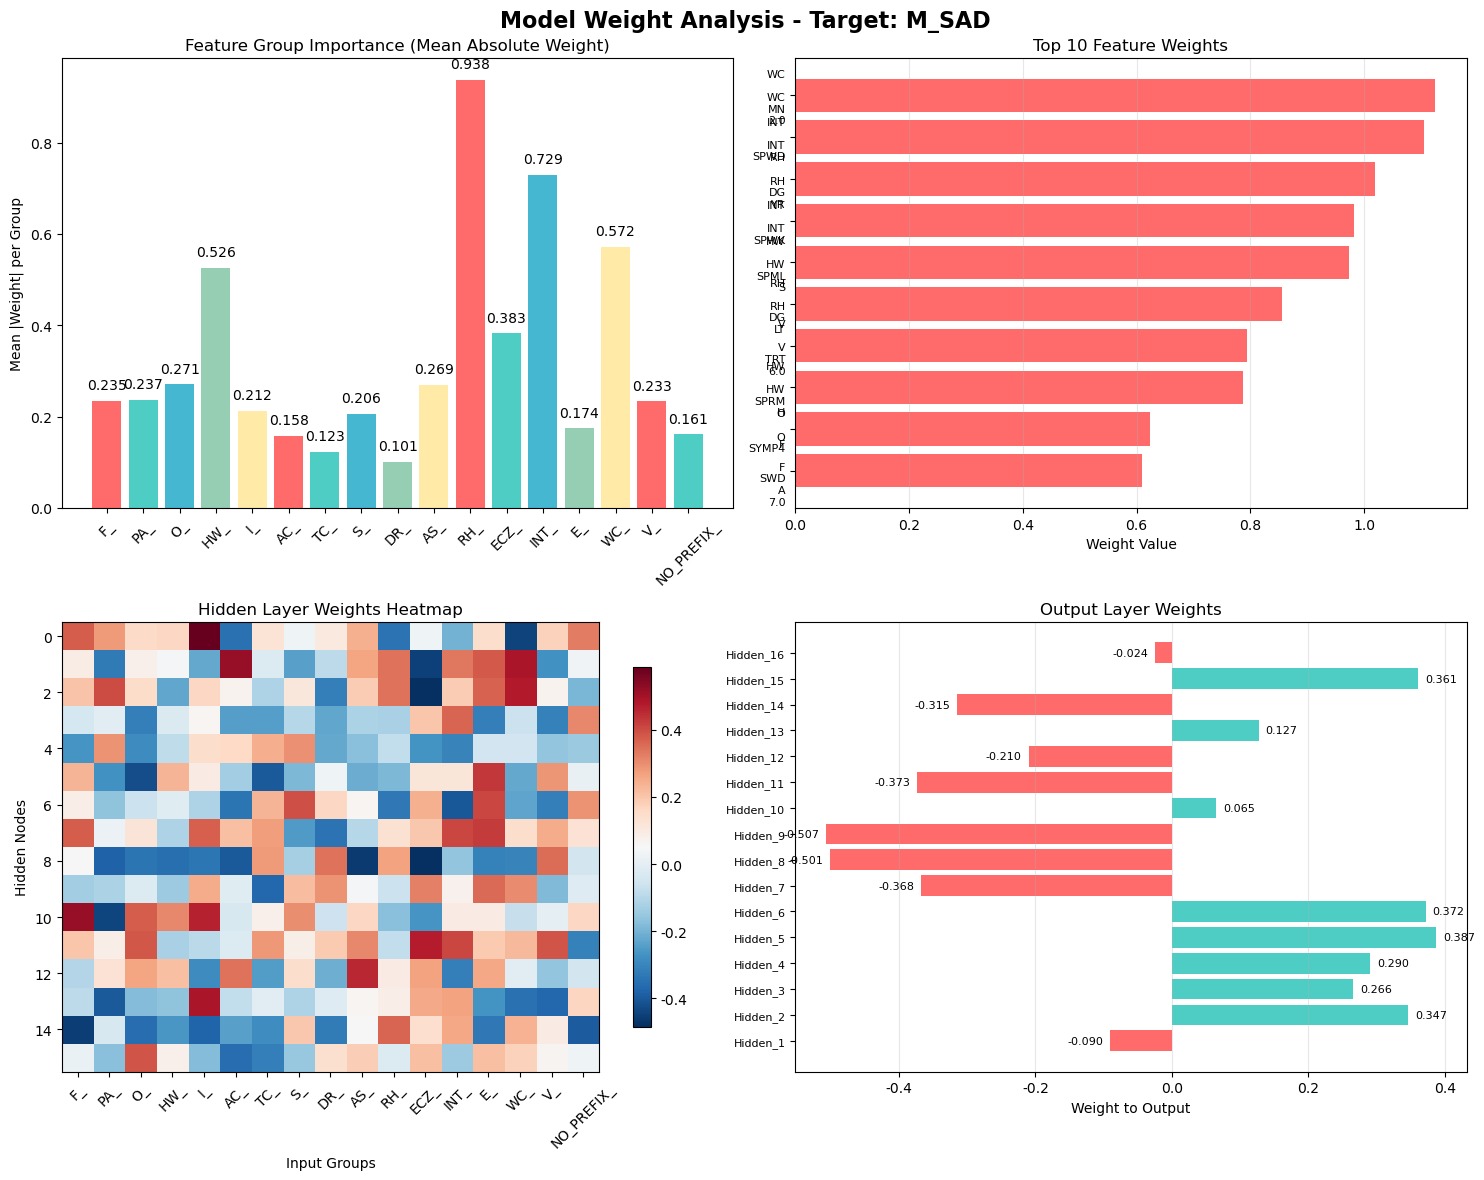

✅ 모델 'M_SAD' 분석 완료!

🚀 모델 학습 시작: Target = M_SUI_CON
🔄 모델 학습 중...
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 7.

📊 학습 결과 요약 - Target: M_SUI_CON
🔄 총 에포크 수: 11
📉 최종 Training Loss: 0.3499
📉 최종 Validation Loss: 0.3576
📈 최종 Training Accuracy: 0.8747
📈 최종 Validation Accuracy: 0.8711
📈 최종 테스트 정확도: 0.8713
📉 최종 테스트 Loss: 0.3576

🎨 가중치 시각화 생성 중...


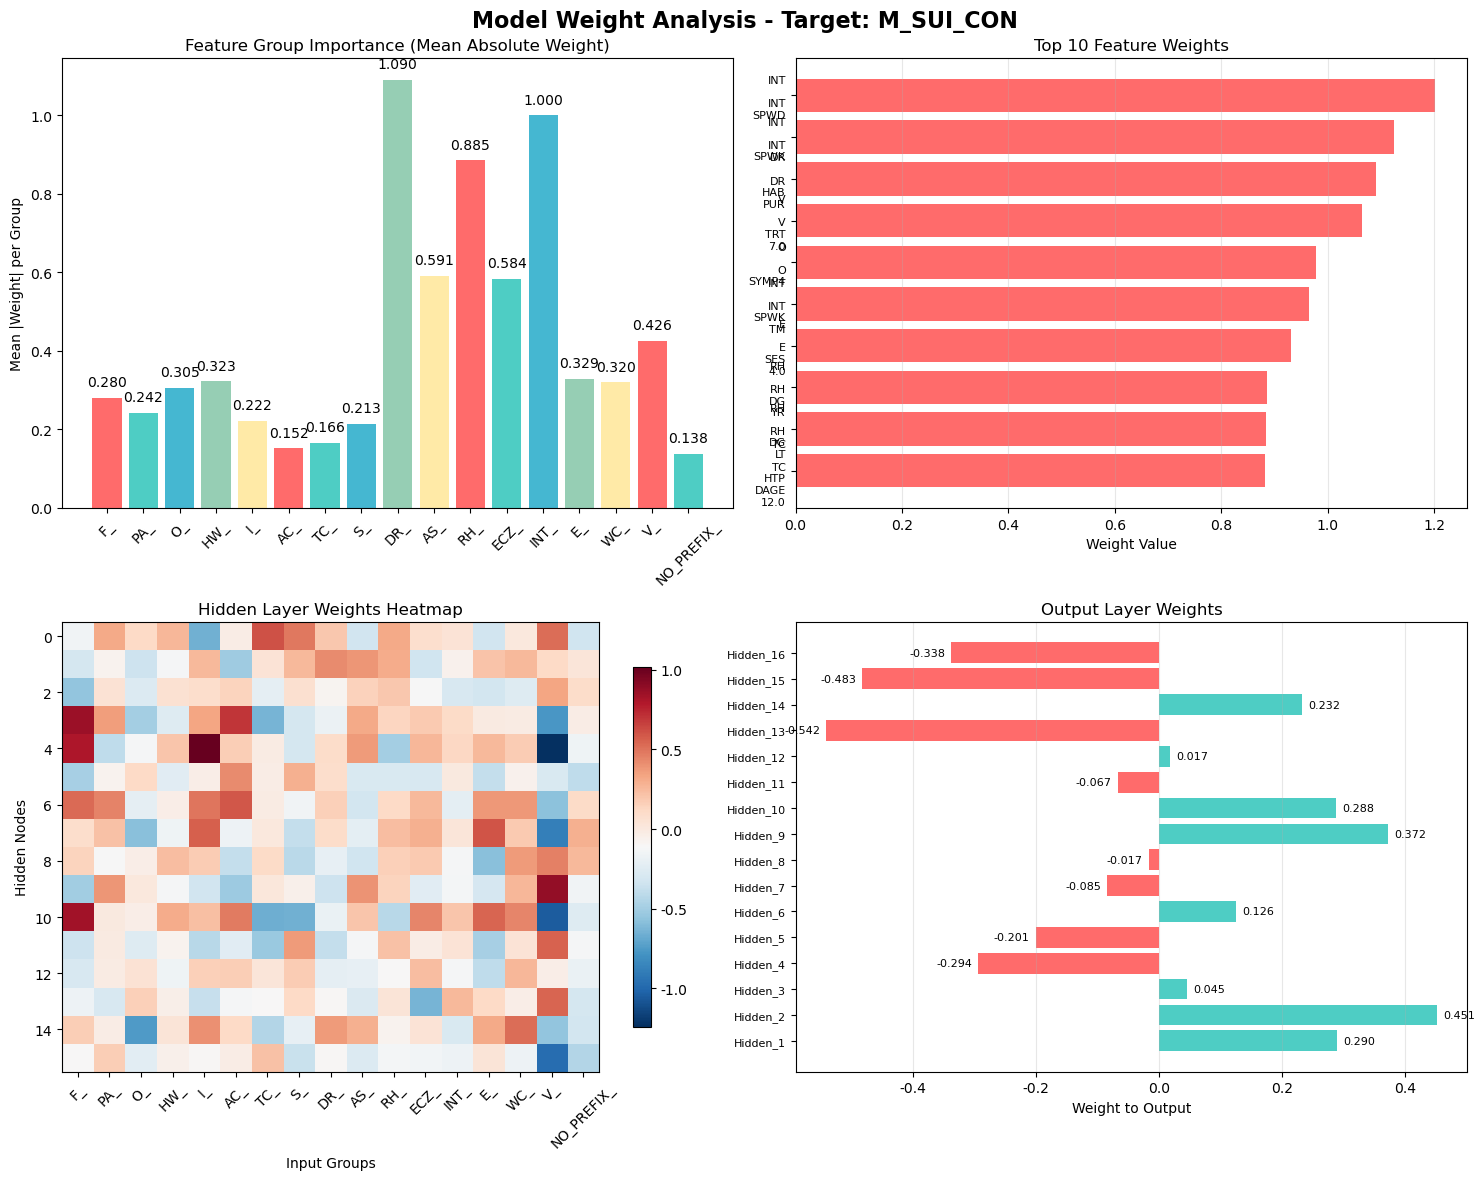

✅ 모델 'M_SUI_CON' 분석 완료!

🚀 모델 학습 시작: Target = M_SUI_PLN
🔄 모델 학습 중...
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 7.

📊 학습 결과 요약 - Target: M_SUI_PLN
🔄 총 에포크 수: 11
📉 최종 Training Loss: 0.1741
📉 최종 Validation Loss: 0.1743
📈 최종 Training Accuracy: 0.9514
📈 최종 Validation Accuracy: 0.9518
📈 최종 테스트 정확도: 0.9518
📉 최종 테스트 Loss: 0.1740

🎨 가중치 시각화 생성 중...


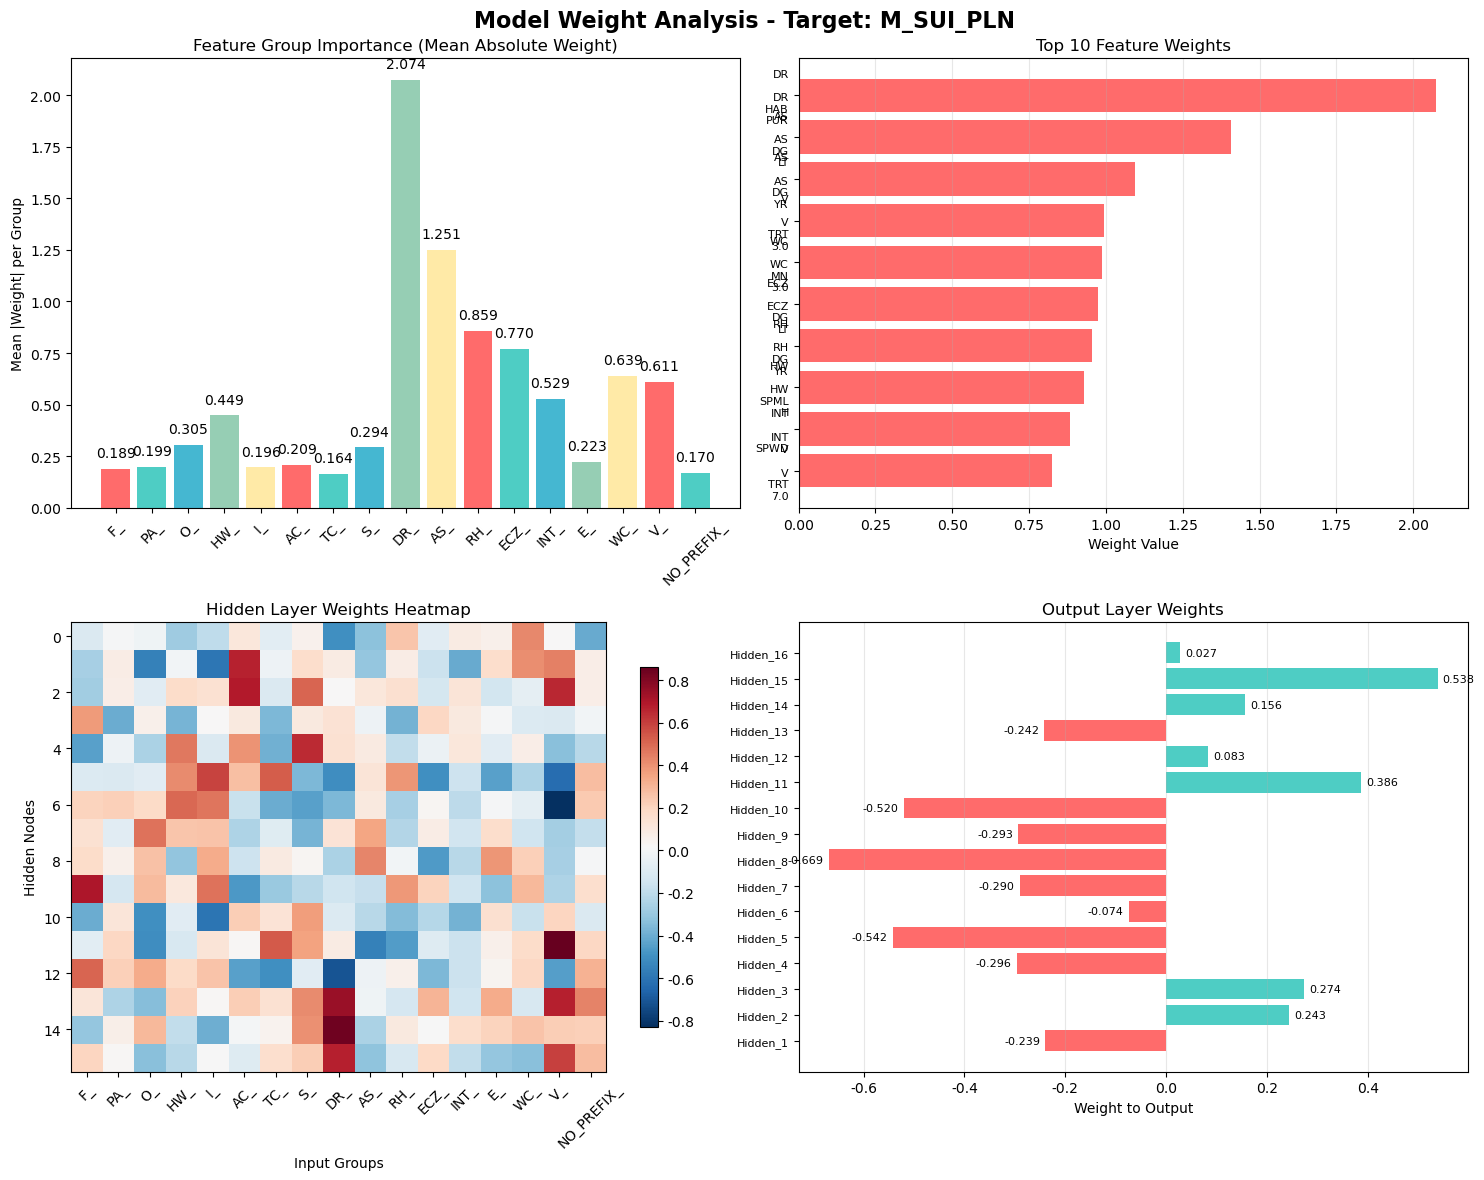

✅ 모델 'M_SUI_PLN' 분석 완료!

🚀 모델 학습 시작: Target = M_SUI_ATT
🔄 모델 학습 중...
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 7.

📊 학습 결과 요약 - Target: M_SUI_ATT
🔄 총 에포크 수: 11
📉 최종 Training Loss: 0.1087
📉 최종 Validation Loss: 0.1178
📈 최종 Training Accuracy: 0.9728
📈 최종 Validation Accuracy: 0.9706
📈 최종 테스트 정확도: 0.9711
📉 최종 테스트 Loss: 0.1167

🎨 가중치 시각화 생성 중...


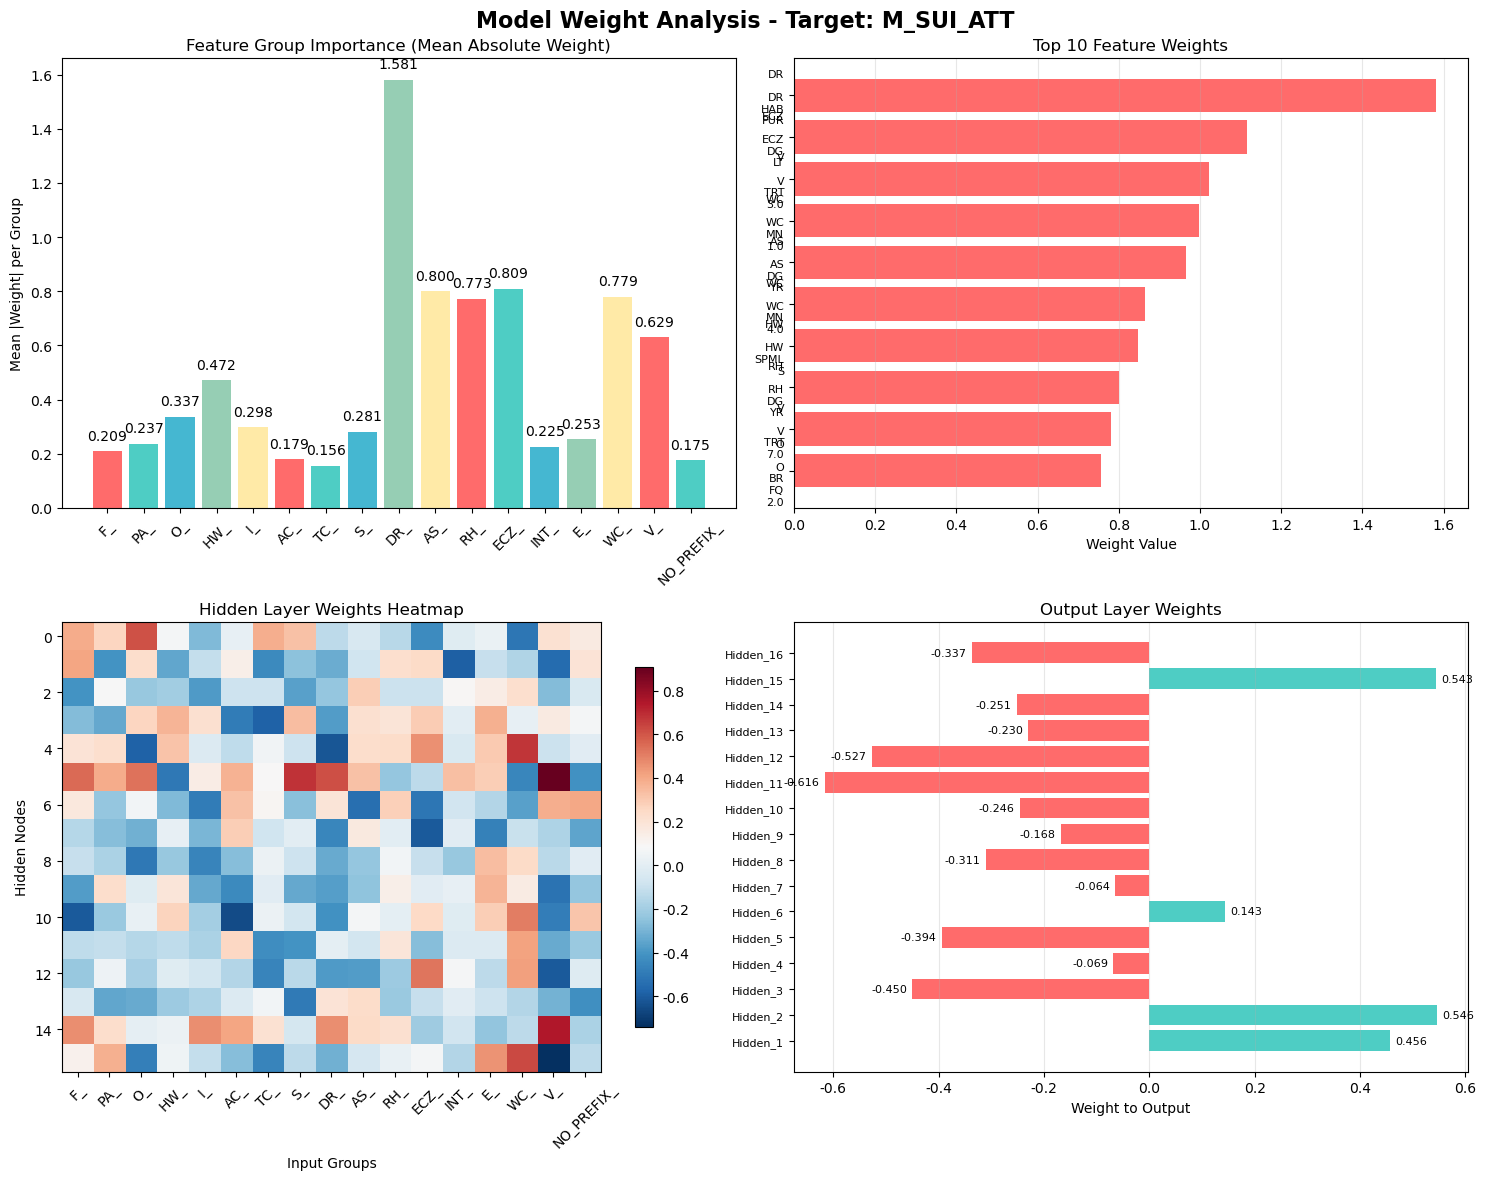

✅ 모델 'M_SUI_ATT' 분석 완료!

🎉 전체 학습 완료! 총 4개 모델이 학습되었습니다.


In [16]:
m_targets_1 = ['M_SAD', 'M_SUI_CON', 'M_SUI_PLN', 'M_SUI_ATT']
learning(m_targets_1)


🚀 모델 학습 시작: Target = M_GAD_1
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_1
🔄 총 에포크 수: 100
📉 최종 Training Loss: -522991239168.0000
📉 최종 Validation Loss: -530231754752.0000
📈 최종 Training Accuracy: 0.5107
📈 최종 Validation Accuracy: 0.5107
📈 최종 테스트 정확도: 0.5107
📉 최종 테스트 Loss: -530231754752.0000

🎨 가중치 시각화 생성 중...


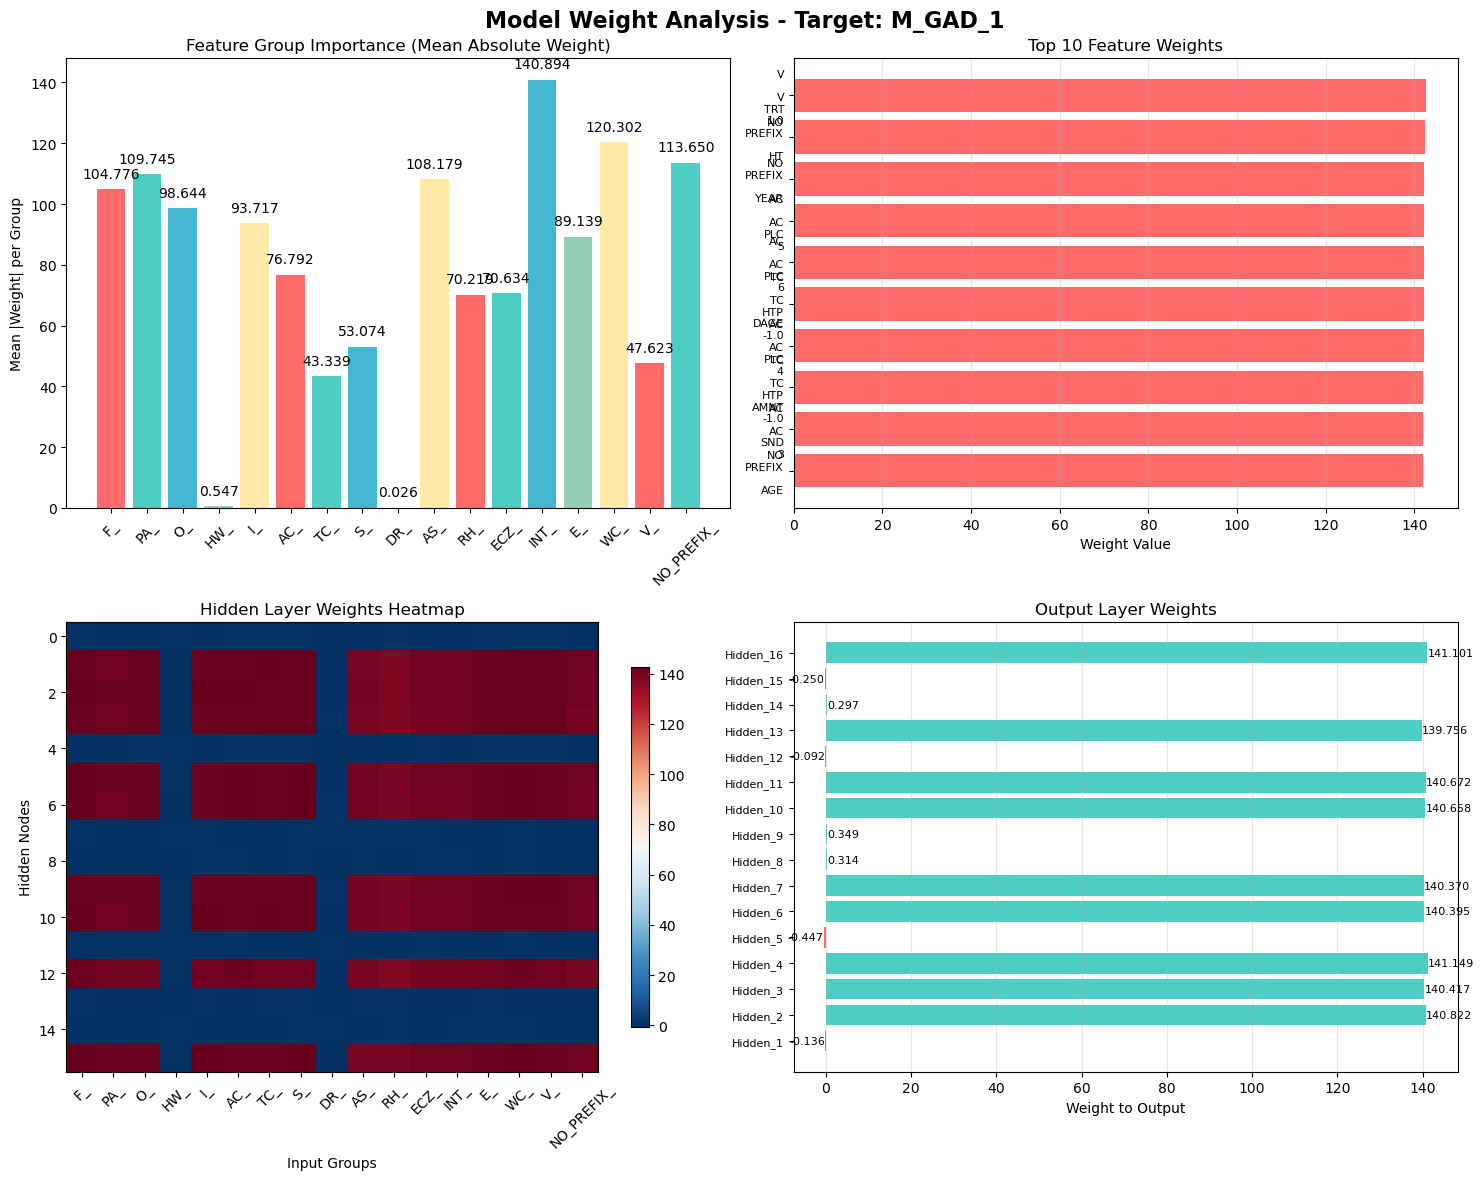

✅ 모델 'M_GAD_1' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_2
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_2
🔄 총 에포크 수: 100
📉 최종 Training Loss: -43930906624.0000
📉 최종 Validation Loss: -43927707648.0000
📈 최종 Training Accuracy: 0.5315
📈 최종 Validation Accuracy: 0.5371
📈 최종 테스트 정확도: 0.5371
📉 최종 테스트 Loss: -43927707648.0000

🎨 가중치 시각화 생성 중...


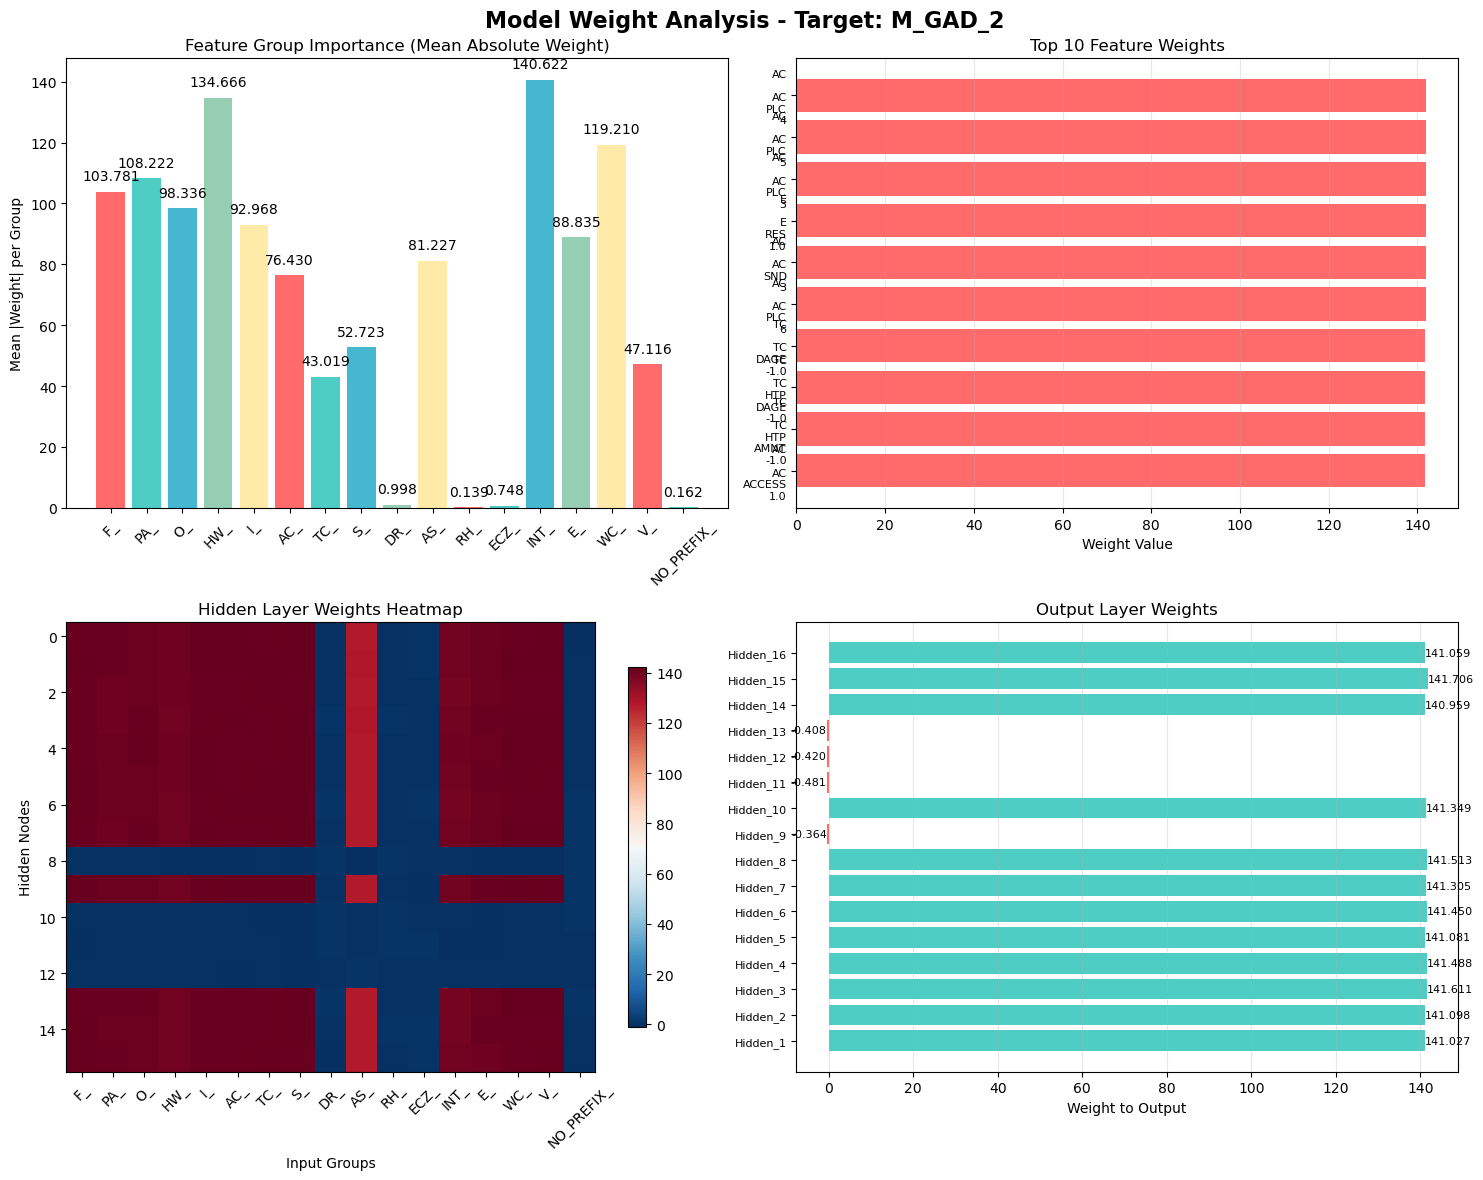

✅ 모델 'M_GAD_2' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_3
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_3
🔄 총 에포크 수: 100
📉 최종 Training Loss: -22995208192.0000
📉 최종 Validation Loss: -23300831232.0000
📈 최종 Training Accuracy: 0.3462
📈 최종 Validation Accuracy: 0.3463
📈 최종 테스트 정확도: 0.3463
📉 최종 테스트 Loss: -23300831232.0000

🎨 가중치 시각화 생성 중...


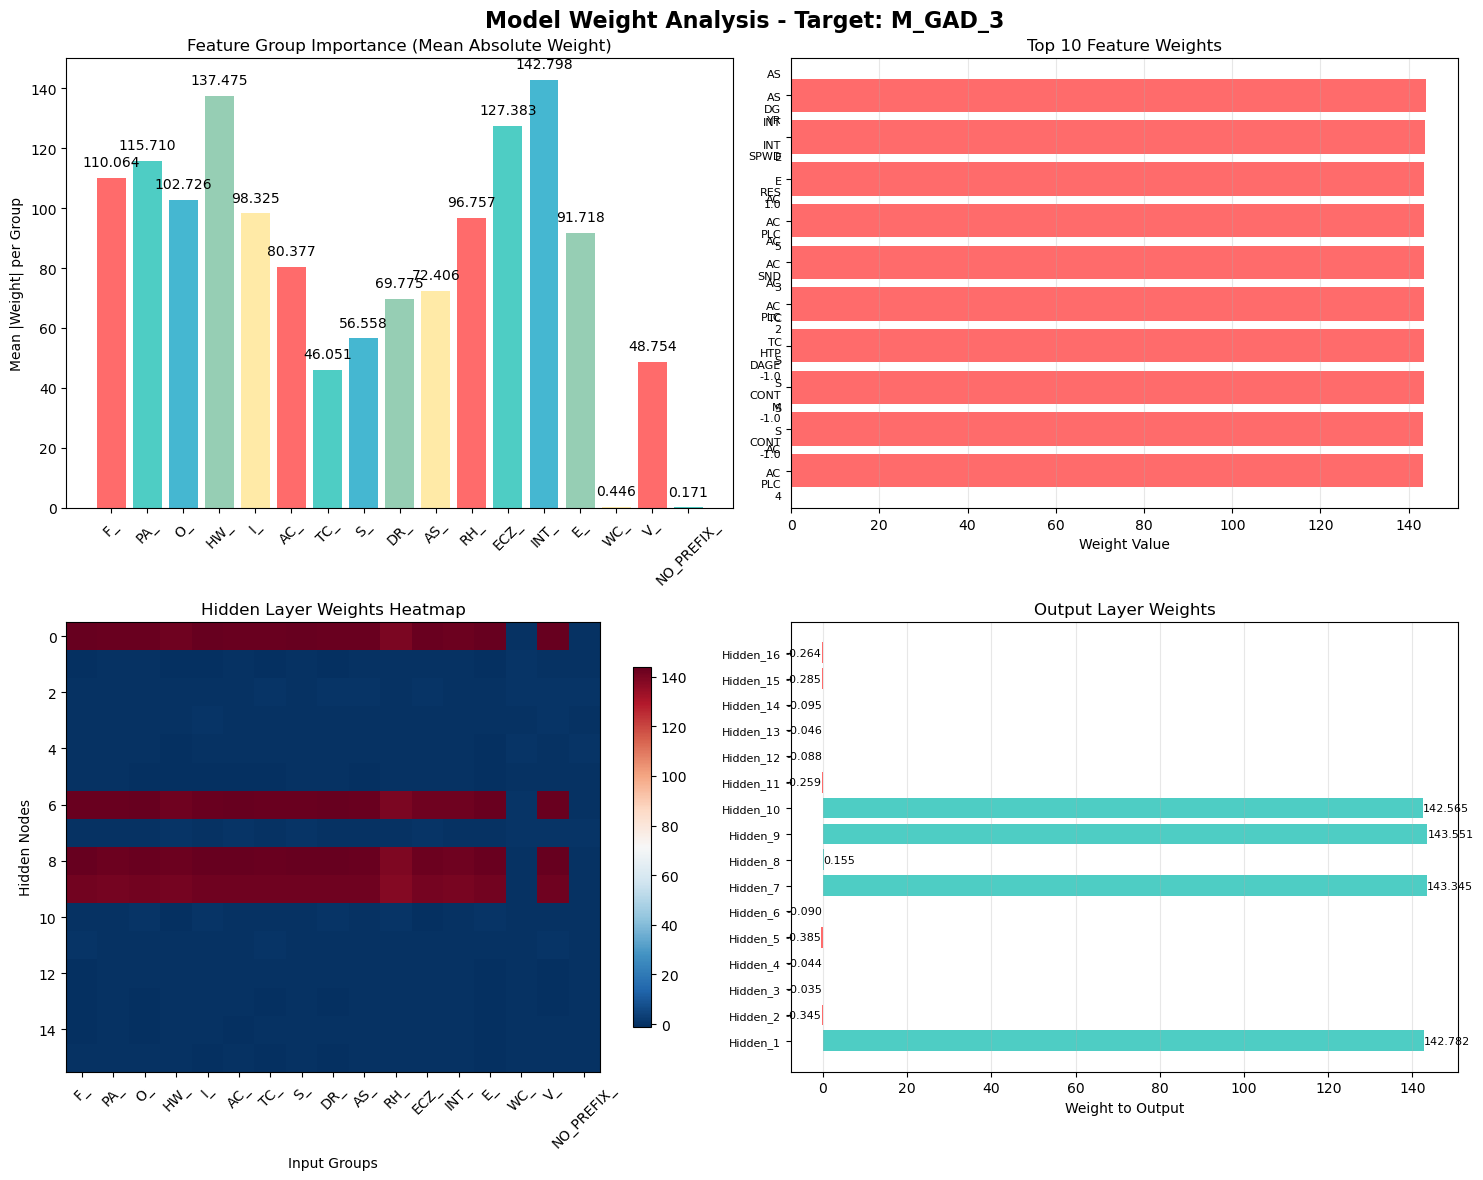

✅ 모델 'M_GAD_3' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_4
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_4
🔄 총 에포크 수: 100
📉 최종 Training Loss: -357244076032.0000
📉 최종 Validation Loss: -361848045568.0000
📈 최종 Training Accuracy: 0.6309
📈 최종 Validation Accuracy: 0.6342
📈 최종 테스트 정확도: 0.6342
📉 최종 테스트 Loss: -361848045568.0000

🎨 가중치 시각화 생성 중...


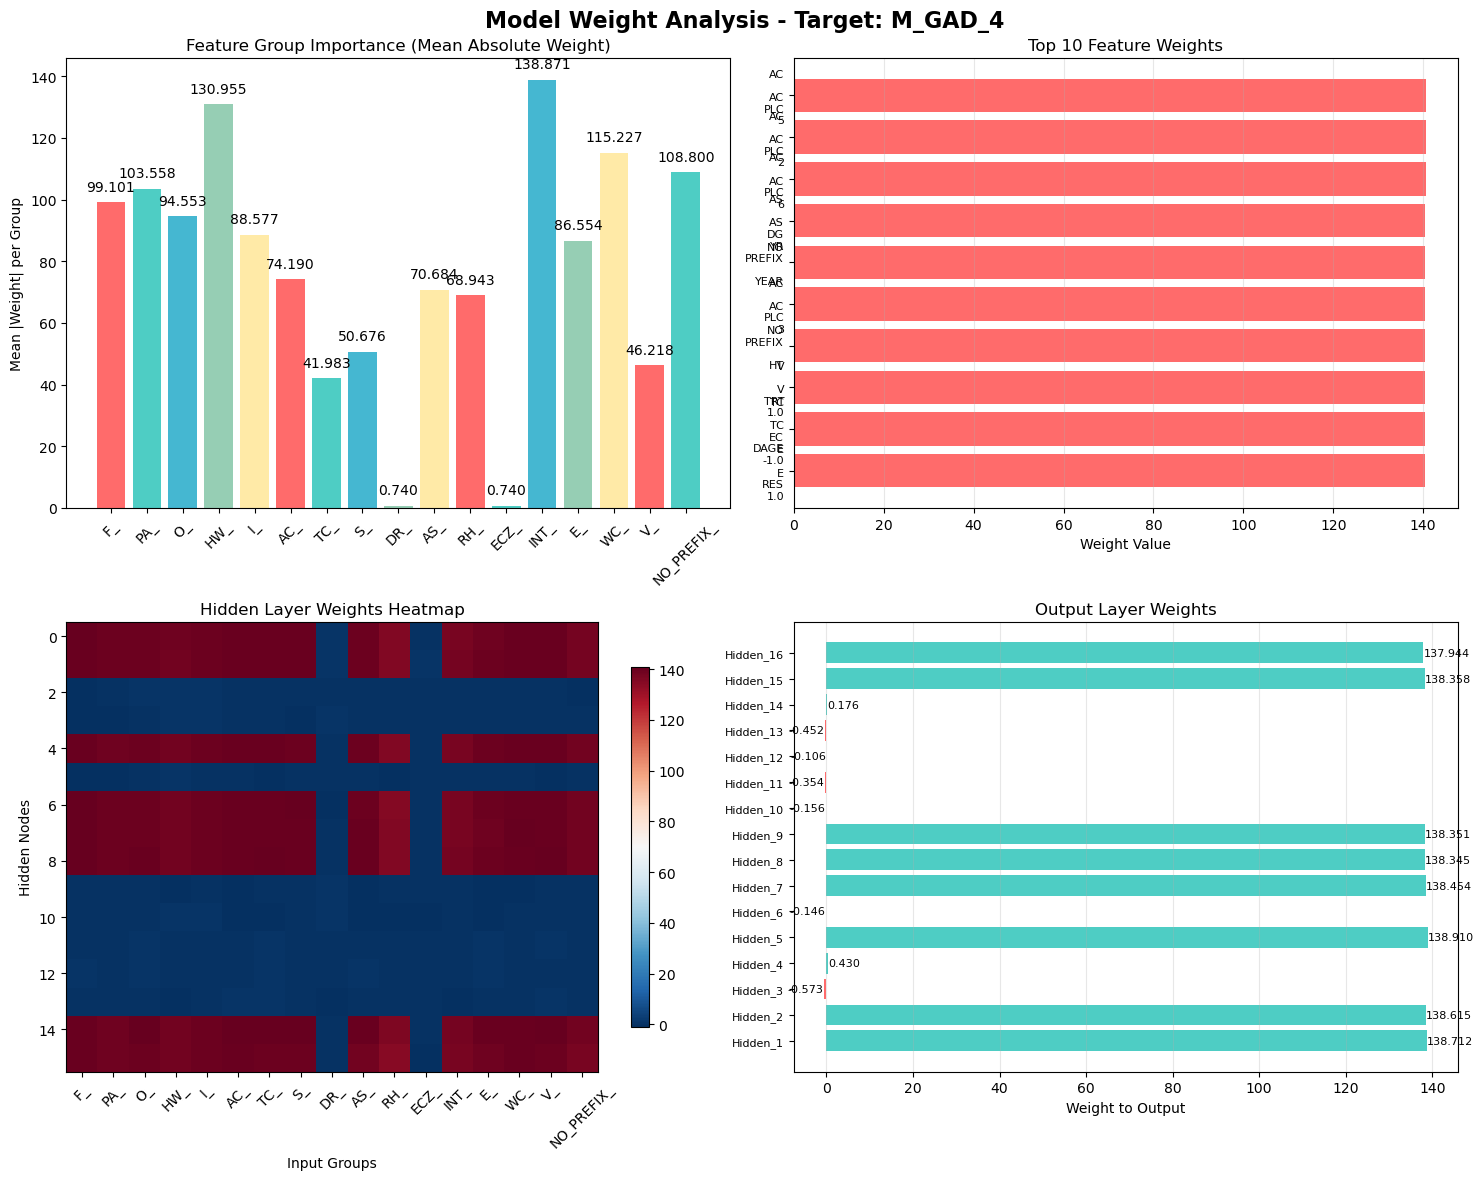

✅ 모델 'M_GAD_4' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_5
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_5
🔄 총 에포크 수: 100
📉 최종 Training Loss: -182213443584.0000
📉 최종 Validation Loss: -183972544512.0000
📈 최종 Training Accuracy: 0.7588
📈 최종 Validation Accuracy: 0.7635
📈 최종 테스트 정확도: 0.7635
📉 최종 테스트 Loss: -183972544512.0000

🎨 가중치 시각화 생성 중...


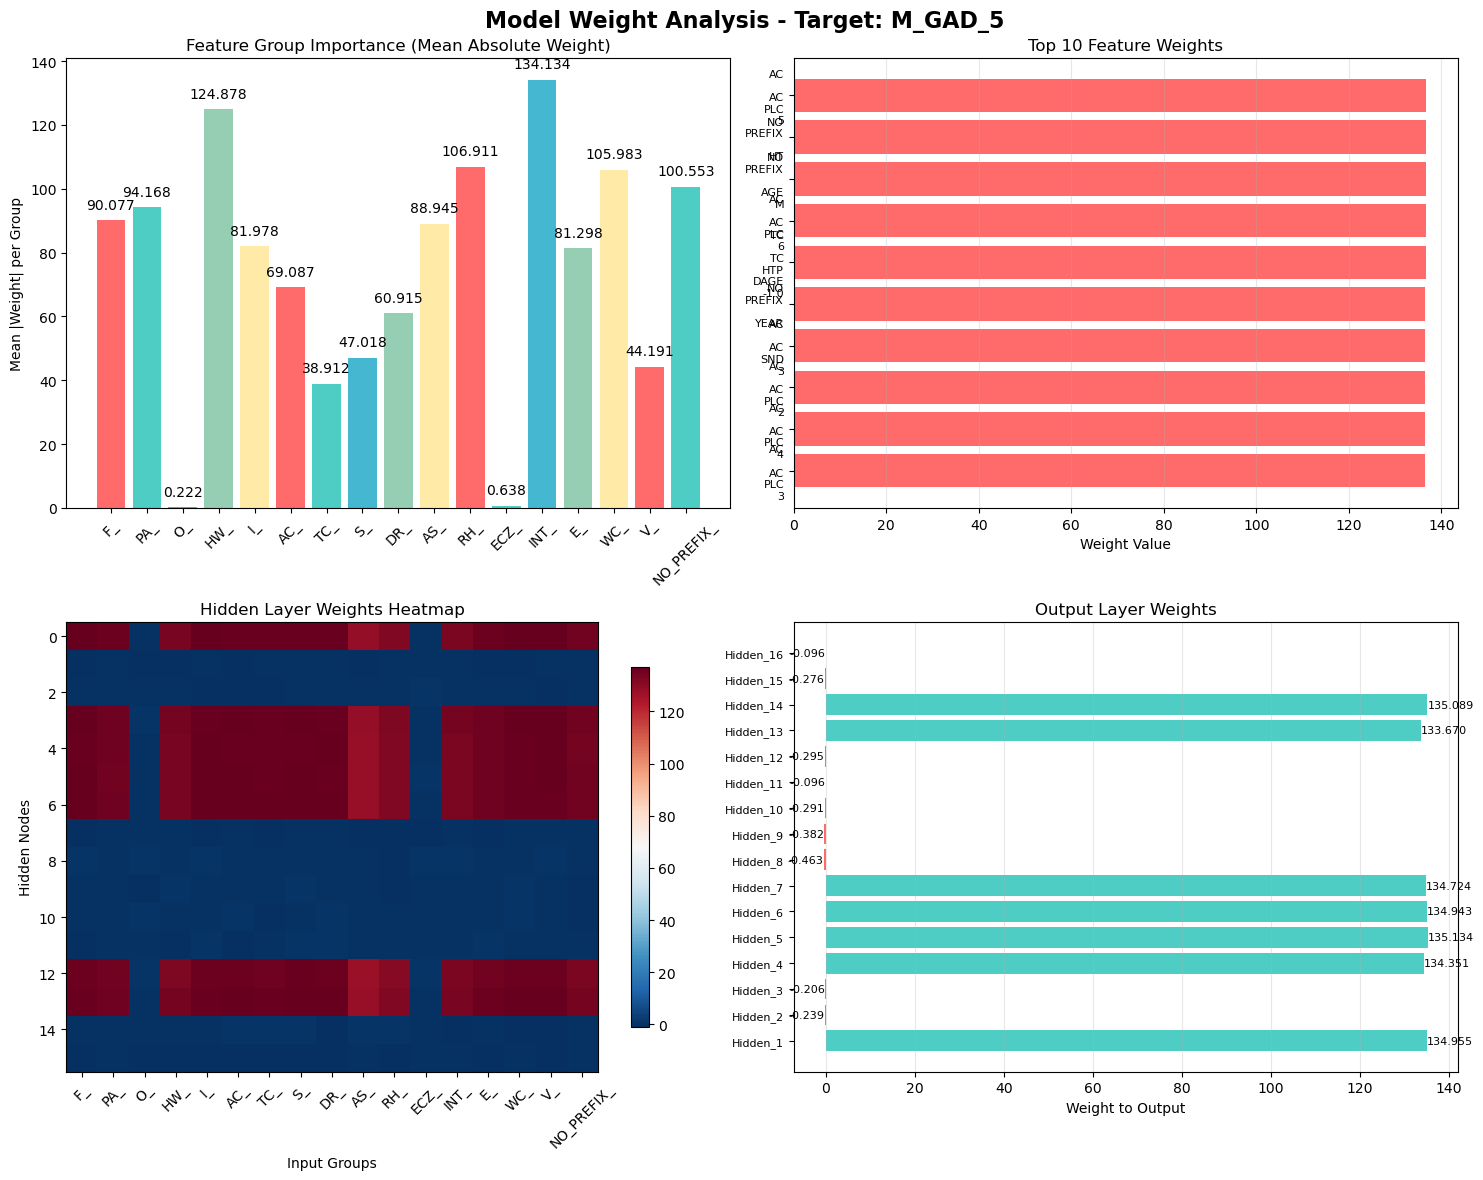

✅ 모델 'M_GAD_5' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_6
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_6
🔄 총 에포크 수: 100
📉 최종 Training Loss: -497014964224.0000
📉 최종 Validation Loss: -499771310080.0000
📈 최종 Training Accuracy: 0.4656
📈 최종 Validation Accuracy: 0.4681
📈 최종 테스트 정확도: 0.4681
📉 최종 테스트 Loss: -499771310080.0000

🎨 가중치 시각화 생성 중...


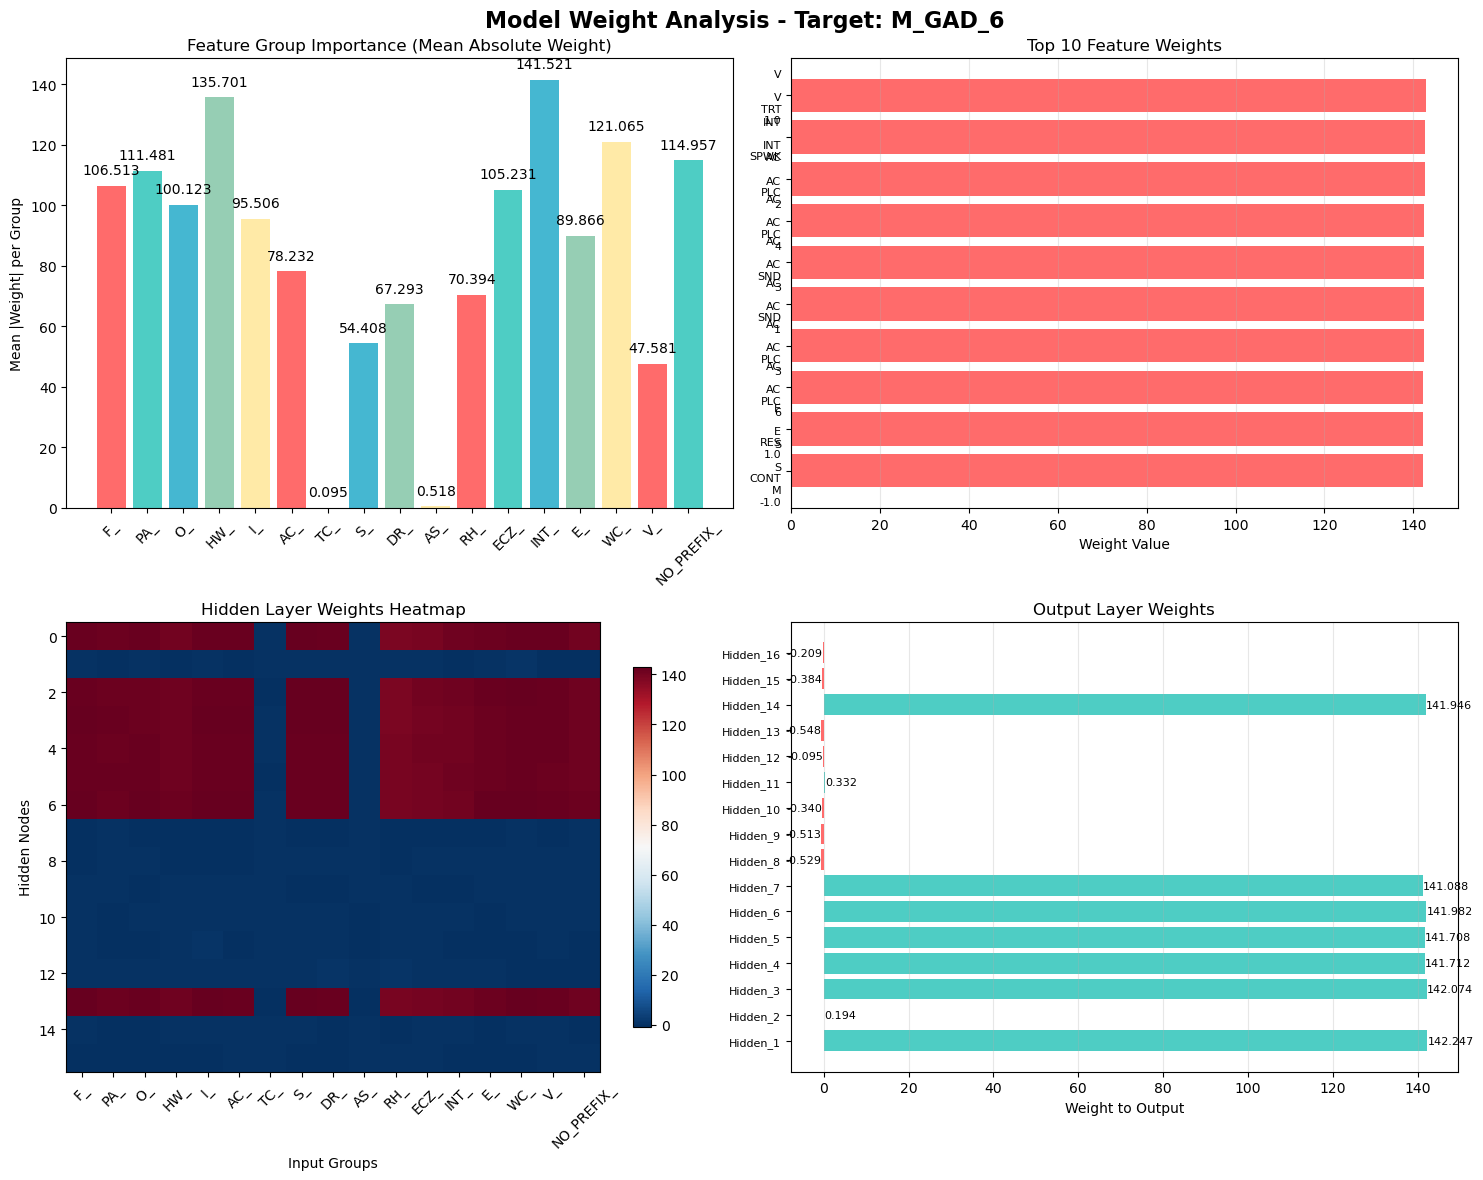

✅ 모델 'M_GAD_6' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_7
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_7
🔄 총 에포크 수: 100
📉 최종 Training Loss: -199584743424.0000
📉 최종 Validation Loss: -200661893120.0000
📈 최종 Training Accuracy: 0.7189
📈 최종 Validation Accuracy: 0.7235
📈 최종 테스트 정확도: 0.7235
📉 최종 테스트 Loss: -200661893120.0000

🎨 가중치 시각화 생성 중...


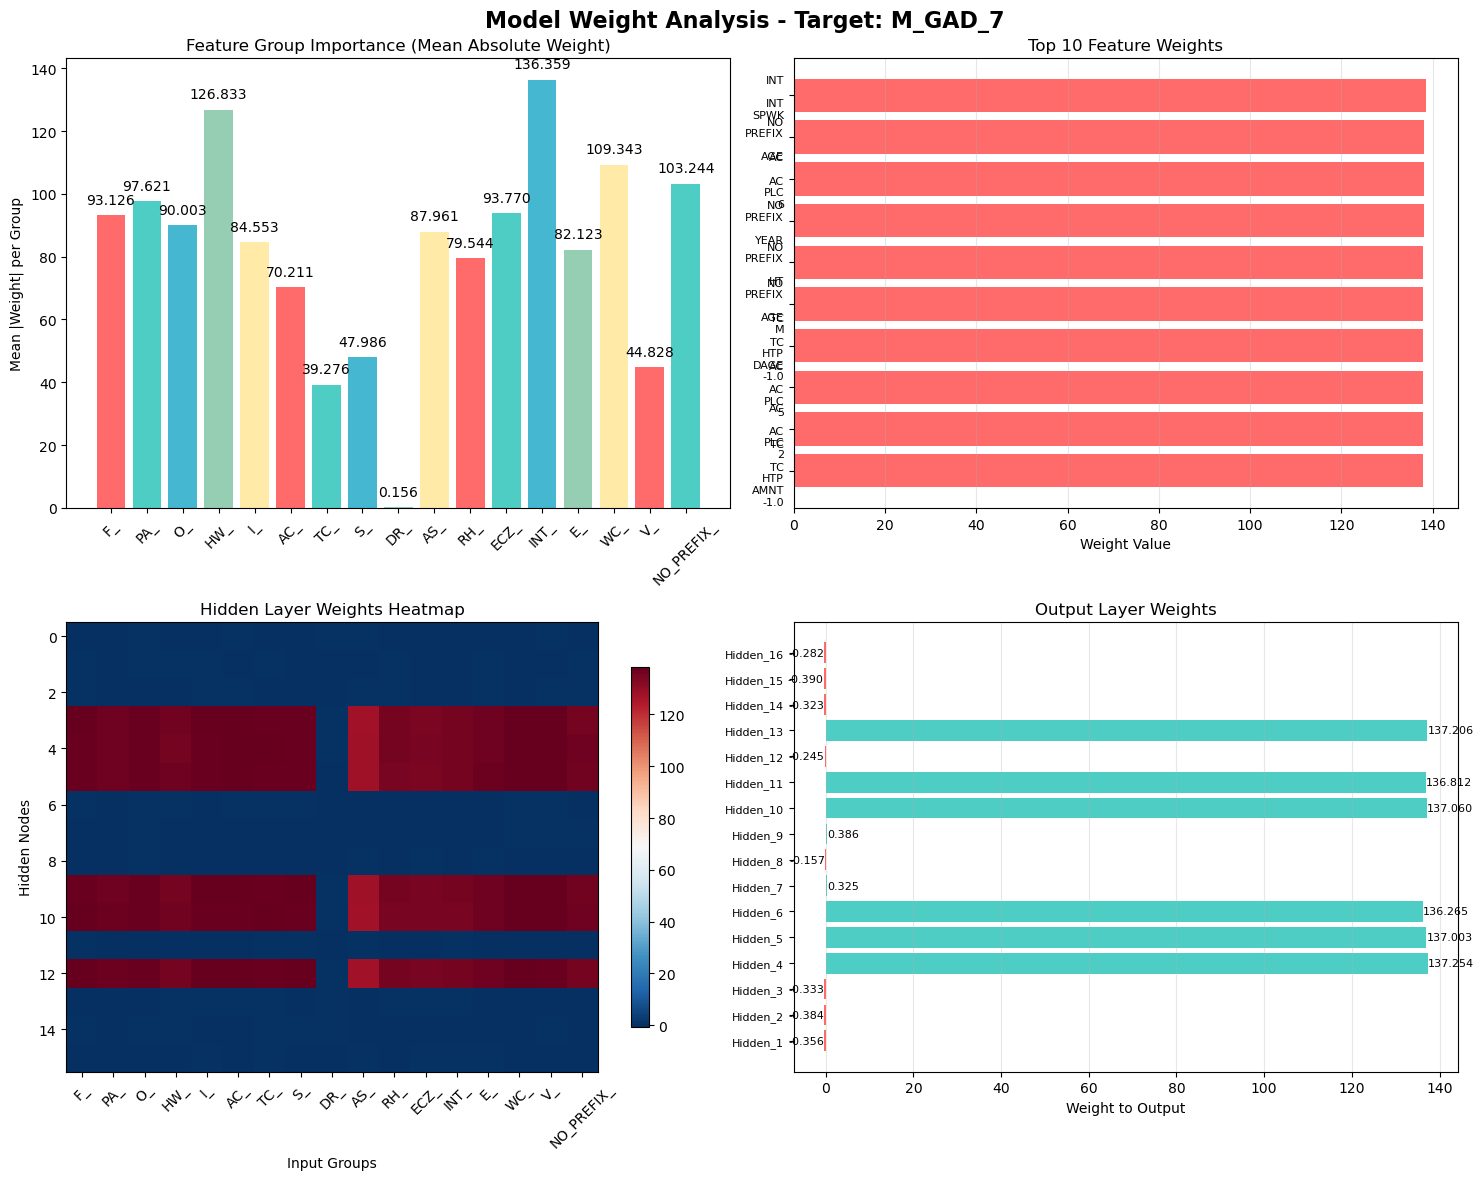

✅ 모델 'M_GAD_7' 분석 완료!

🎉 전체 학습 완료! 총 7개 모델이 학습되었습니다.


In [22]:
m_targets_2 = ['M_GAD_1', 'M_GAD_2', 'M_GAD_3', 'M_GAD_4', 'M_GAD_5', 'M_GAD_6', 'M_GAD_7']
learning(m_targets_2)


🚀 모델 학습 시작: Target = M_GAD_TOTAL
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_TOTAL
🔄 총 에포크 수: 100
📉 최종 Training Loss: -2973256122368.0000
📉 최종 Validation Loss: -2991690612736.0000
📈 최종 Training Accuracy: 0.1099
📈 최종 Validation Accuracy: 0.1100
📈 최종 테스트 정확도: 0.1100
📉 최종 테스트 Loss: -2991690612736.0000

🎨 가중치 시각화 생성 중...


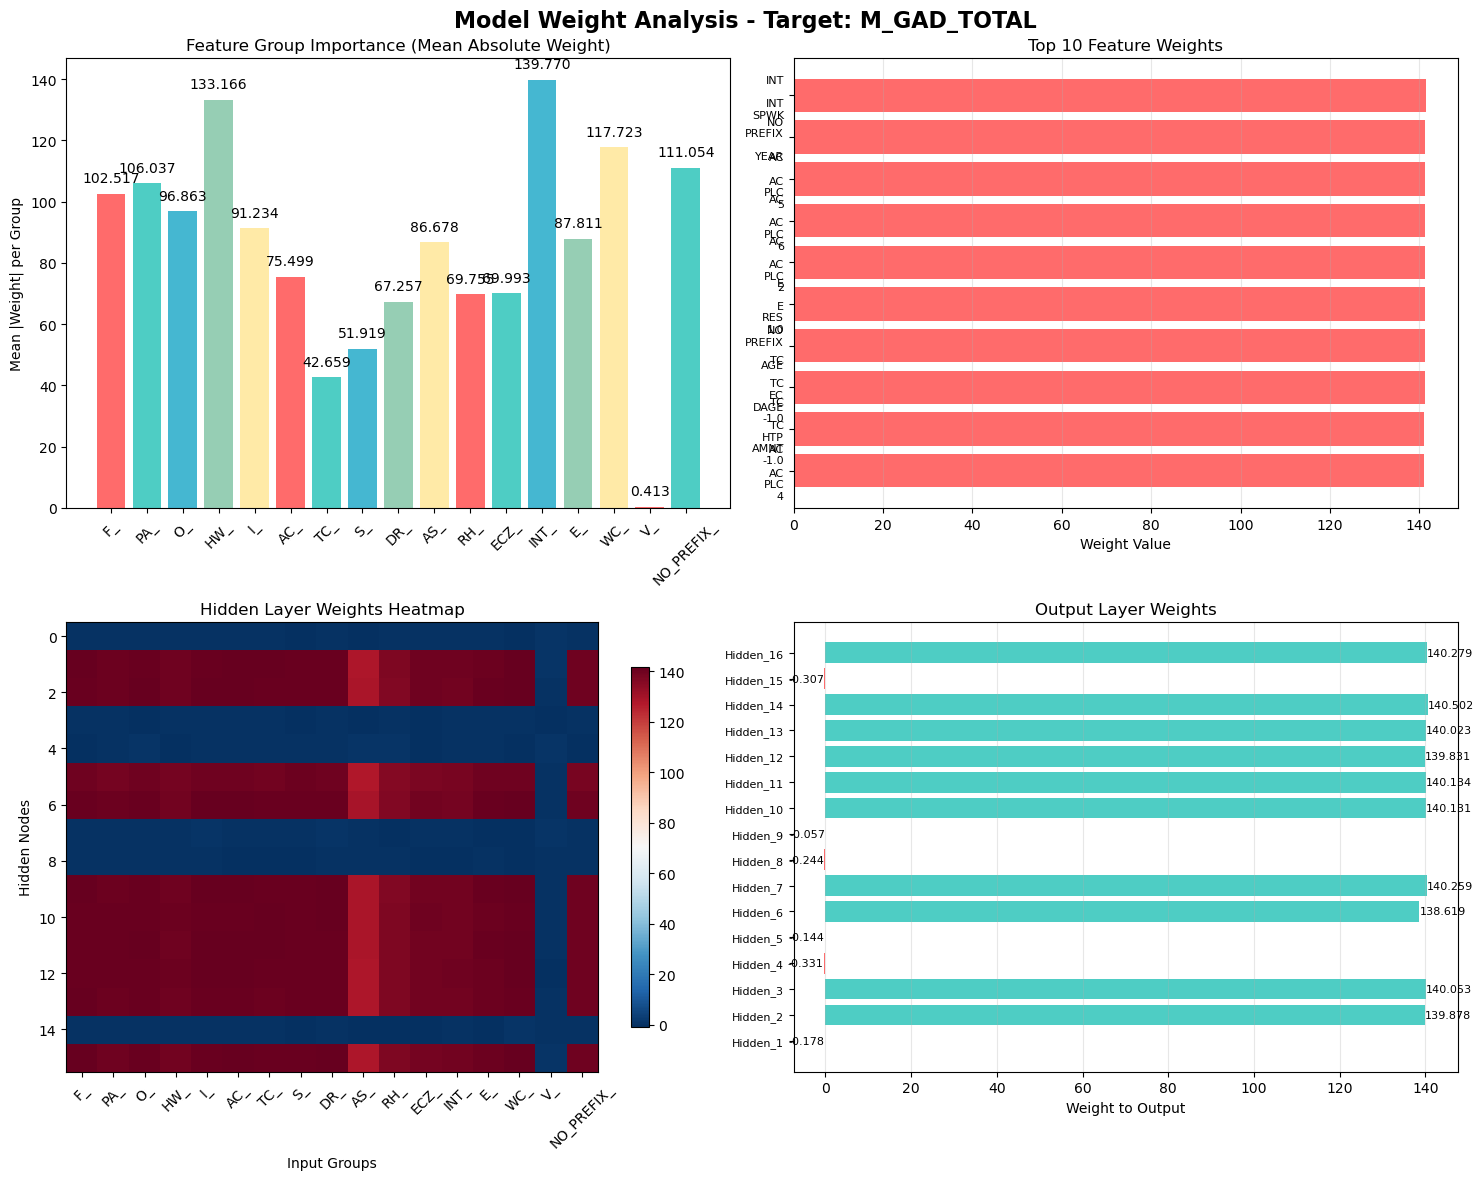

✅ 모델 'M_GAD_TOTAL' 분석 완료!

🚀 모델 학습 시작: Target = M_GAD_SEVERITY
🔄 모델 학습 중...
Restoring model weights from the end of the best epoch: 100.

📊 학습 결과 요약 - Target: M_GAD_SEVERITY
🔄 총 에포크 수: 100
📉 최종 Training Loss: -6632.8481
📉 최종 Validation Loss: -3954.2661
📈 최종 Training Accuracy: 0.5101
📈 최종 Validation Accuracy: 0.4926
📈 최종 테스트 정확도: 0.4926
📉 최종 테스트 Loss: -3954.2661

🎨 가중치 시각화 생성 중...


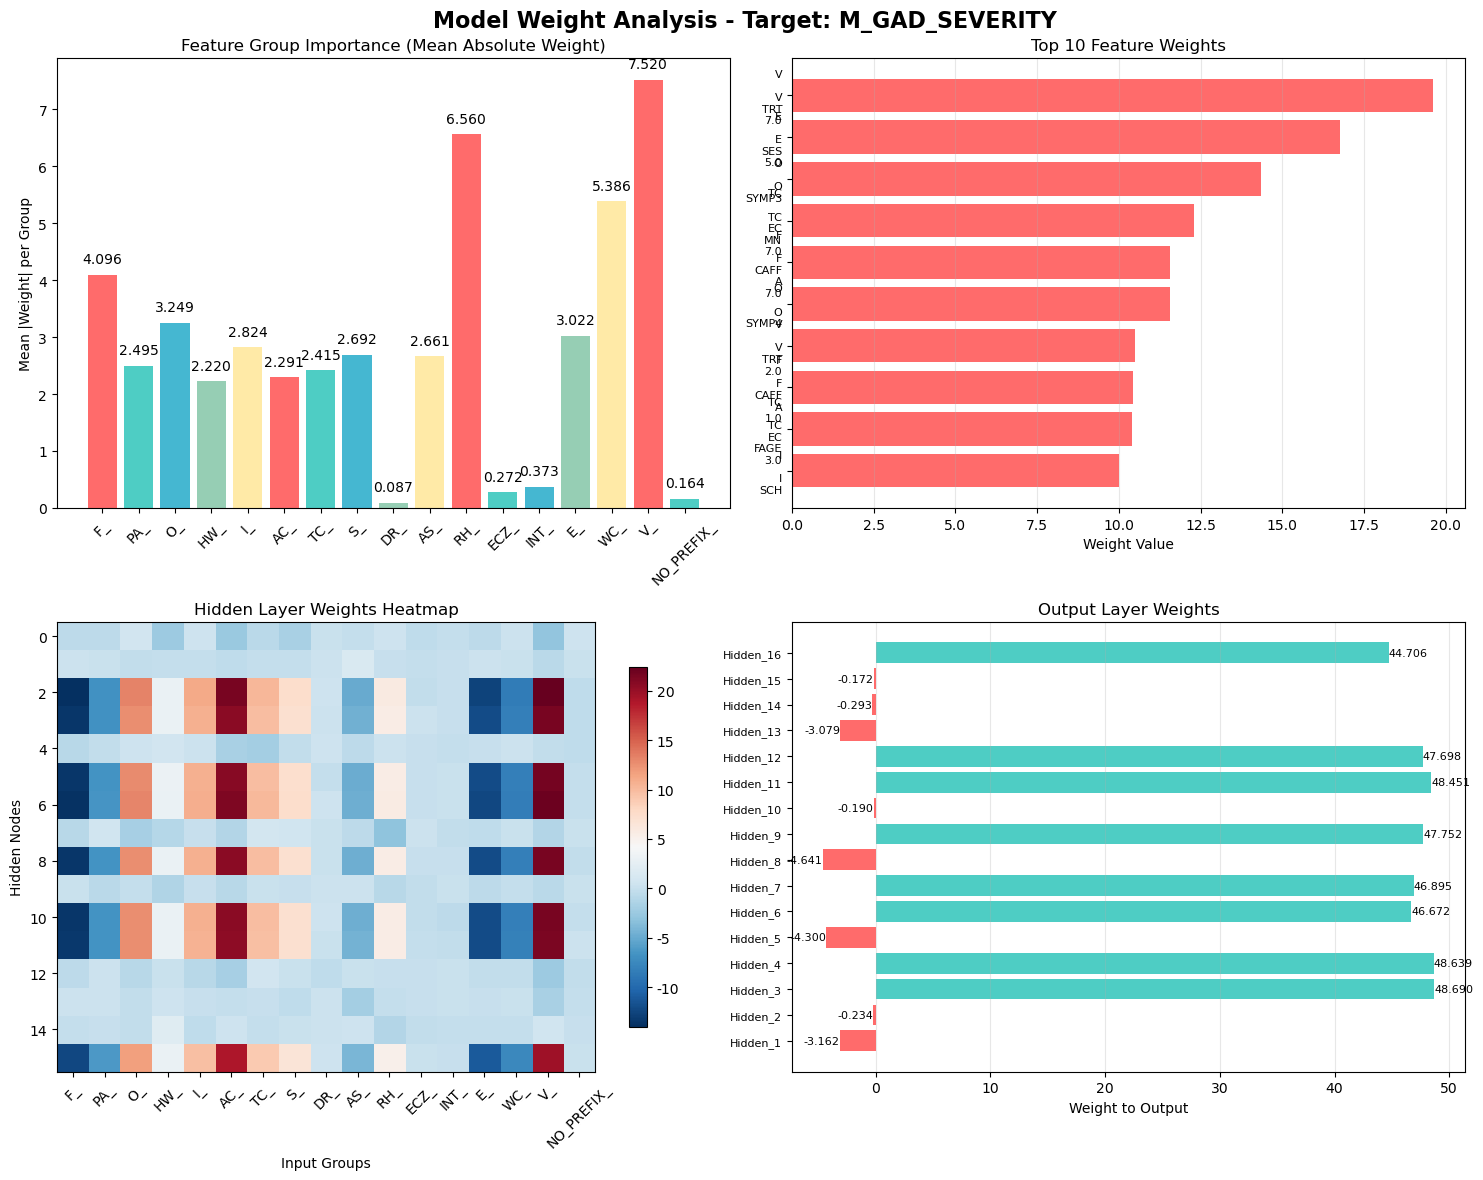

✅ 모델 'M_GAD_SEVERITY' 분석 완료!

🎉 전체 학습 완료! 총 2개 모델이 학습되었습니다.


In [21]:
m_targets_3 = ['M_GAD_TOTAL', 'M_GAD_SEVERITY']
learning(m_targets_3)


🚀 모델 학습 시작: Target = M_STR_1.0
🔄 모델 학습 중...
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 12.

📊 학습 결과 요약 - Target: M_STR_1.0
🔄 총 에포크 수: 16
📉 최종 Training Loss: 0.3182
📉 최종 Validation Loss: 0.3246
📈 최종 Training Accuracy: 0.8886
📈 최종 Validation Accuracy: 0.8879
📈 최종 테스트 정확도: 0.8878
📉 최종 테스트 Loss: 0.3230

🎨 가중치 시각화 생성 중...


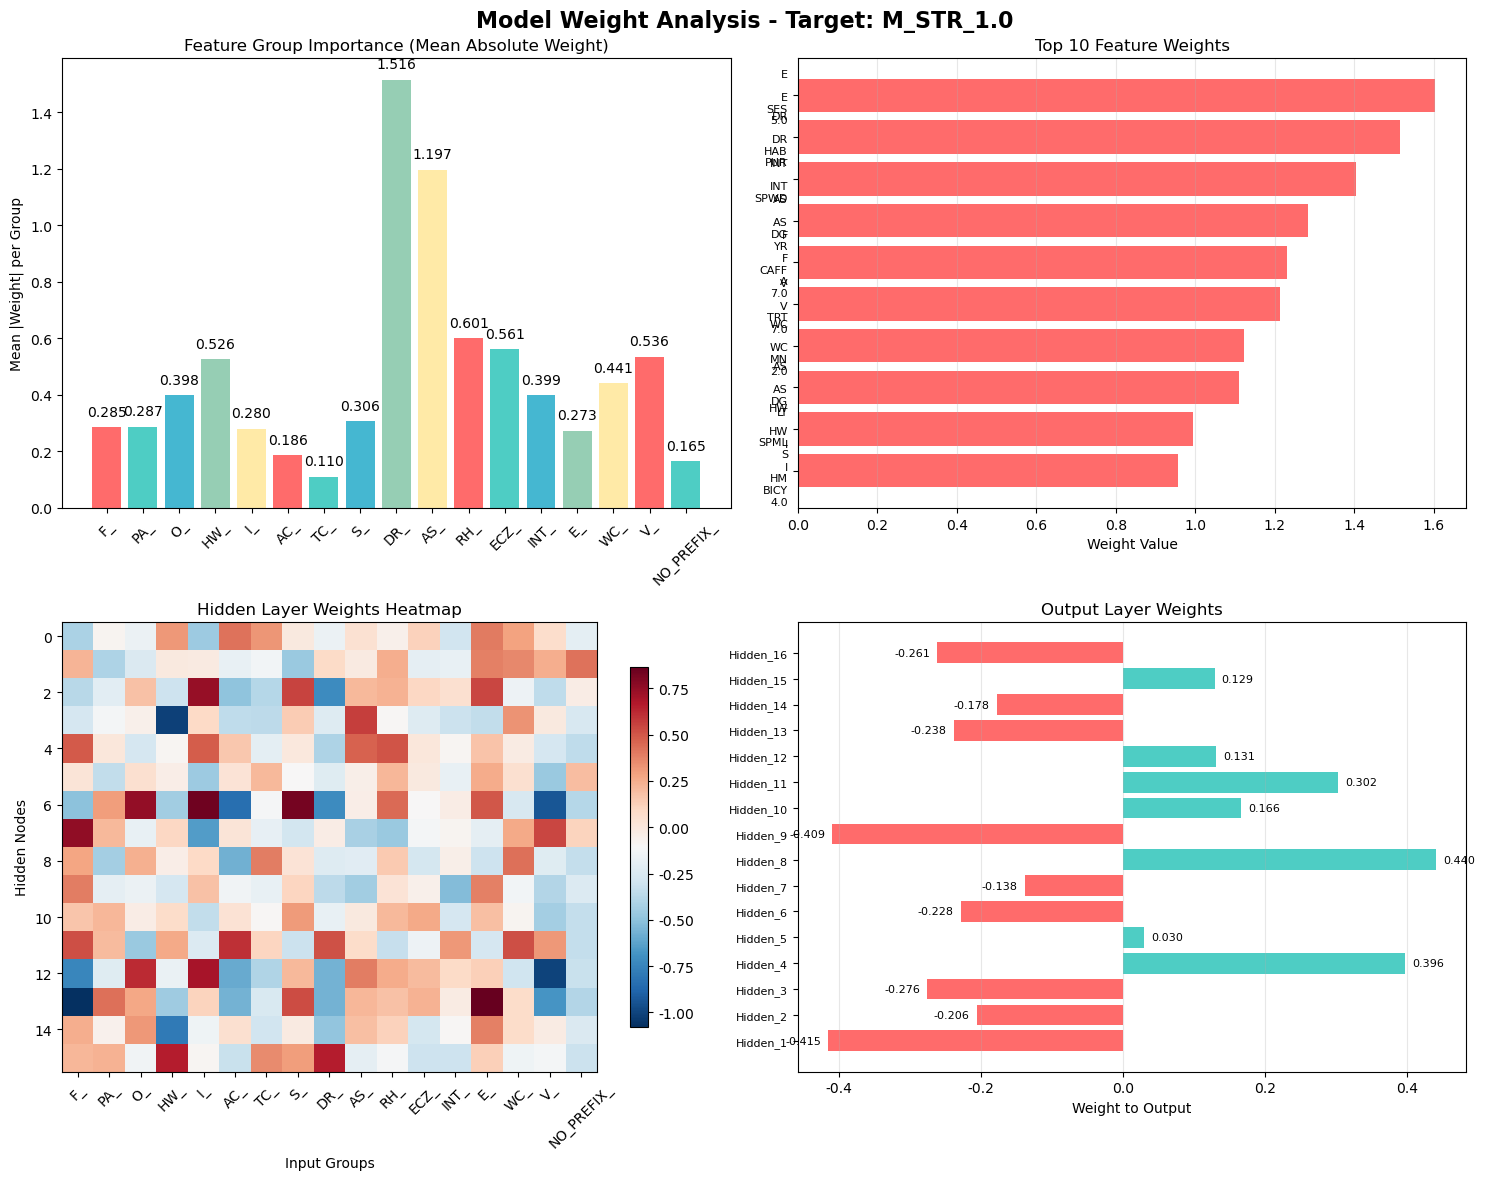

✅ 모델 'M_STR_1.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_2.0
🔄 모델 학습 중...
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 11.

📊 학습 결과 요약 - Target: M_STR_2.0
🔄 총 에포크 수: 15
📉 최종 Training Loss: 0.6055
📉 최종 Validation Loss: 0.6138
📈 최종 Training Accuracy: 0.6908
📈 최종 Validation Accuracy: 0.6916
📈 최종 테스트 정확도: 0.6915
📉 최종 테스트 Loss: 0.6096

🎨 가중치 시각화 생성 중...


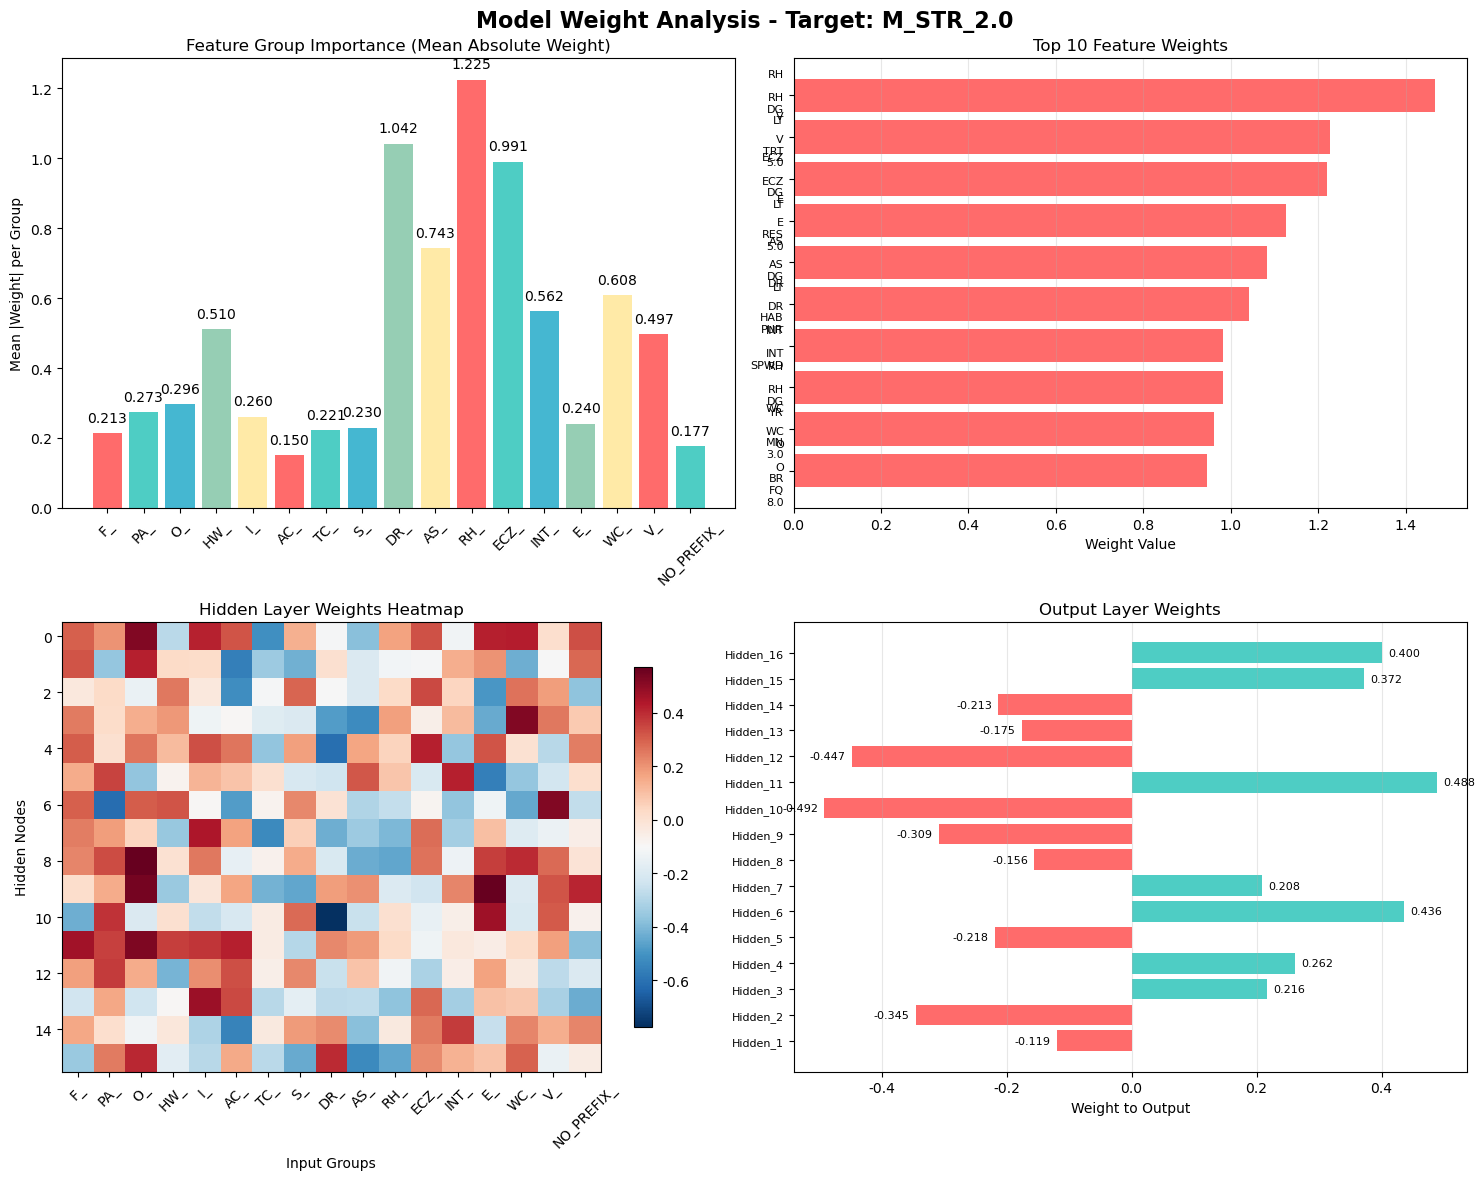

✅ 모델 'M_STR_2.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_3.0
🔄 모델 학습 중...
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 17.

📊 학습 결과 요약 - Target: M_STR_3.0
🔄 총 에포크 수: 21
📉 최종 Training Loss: 0.6652
📉 최종 Validation Loss: 0.6701
📈 최종 Training Accuracy: 0.5848
📈 최종 Validation Accuracy: 0.5830
📈 최종 테스트 정확도: 0.5837
📉 최종 테스트 Loss: 0.6695

🎨 가중치 시각화 생성 중...


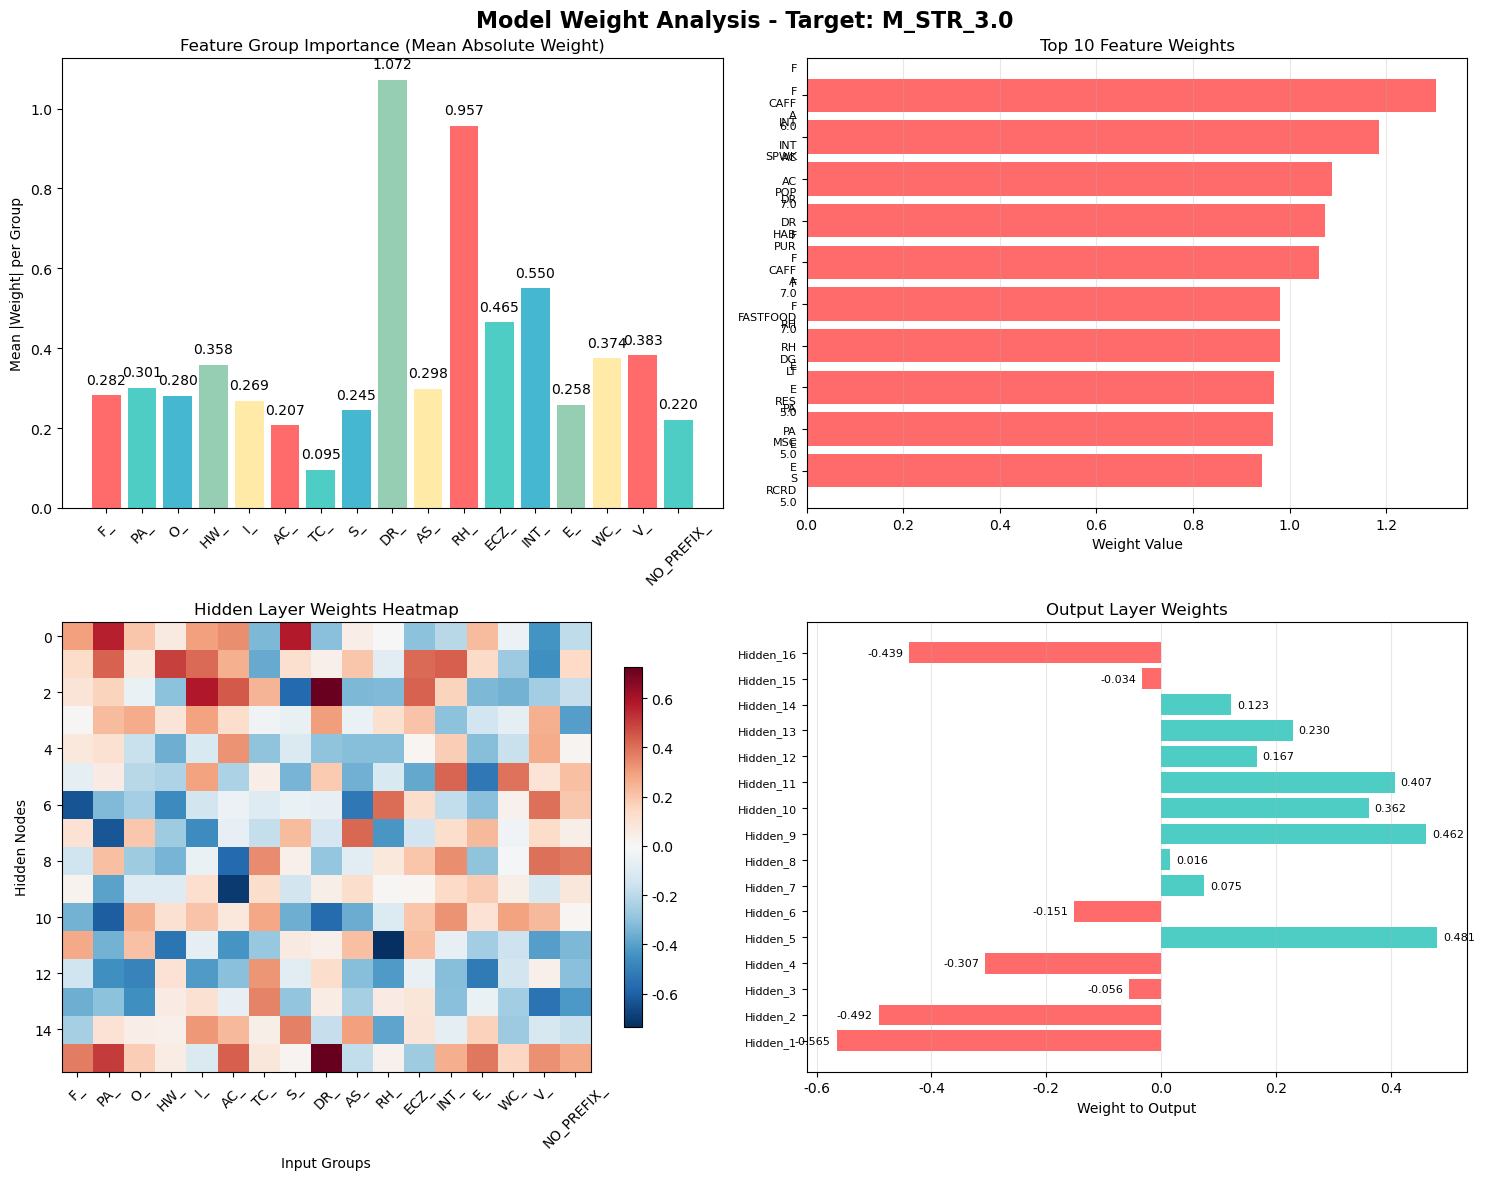

✅ 모델 'M_STR_3.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_4.0
🔄 모델 학습 중...
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 19.

📊 학습 결과 요약 - Target: M_STR_4.0
🔄 총 에포크 수: 23
📉 최종 Training Loss: 0.3656
📉 최종 Validation Loss: 0.3780
📈 최종 Training Accuracy: 0.8713
📈 최종 Validation Accuracy: 0.8689
📈 최종 테스트 정확도: 0.8689
📉 최종 테스트 Loss: 0.3751

🎨 가중치 시각화 생성 중...


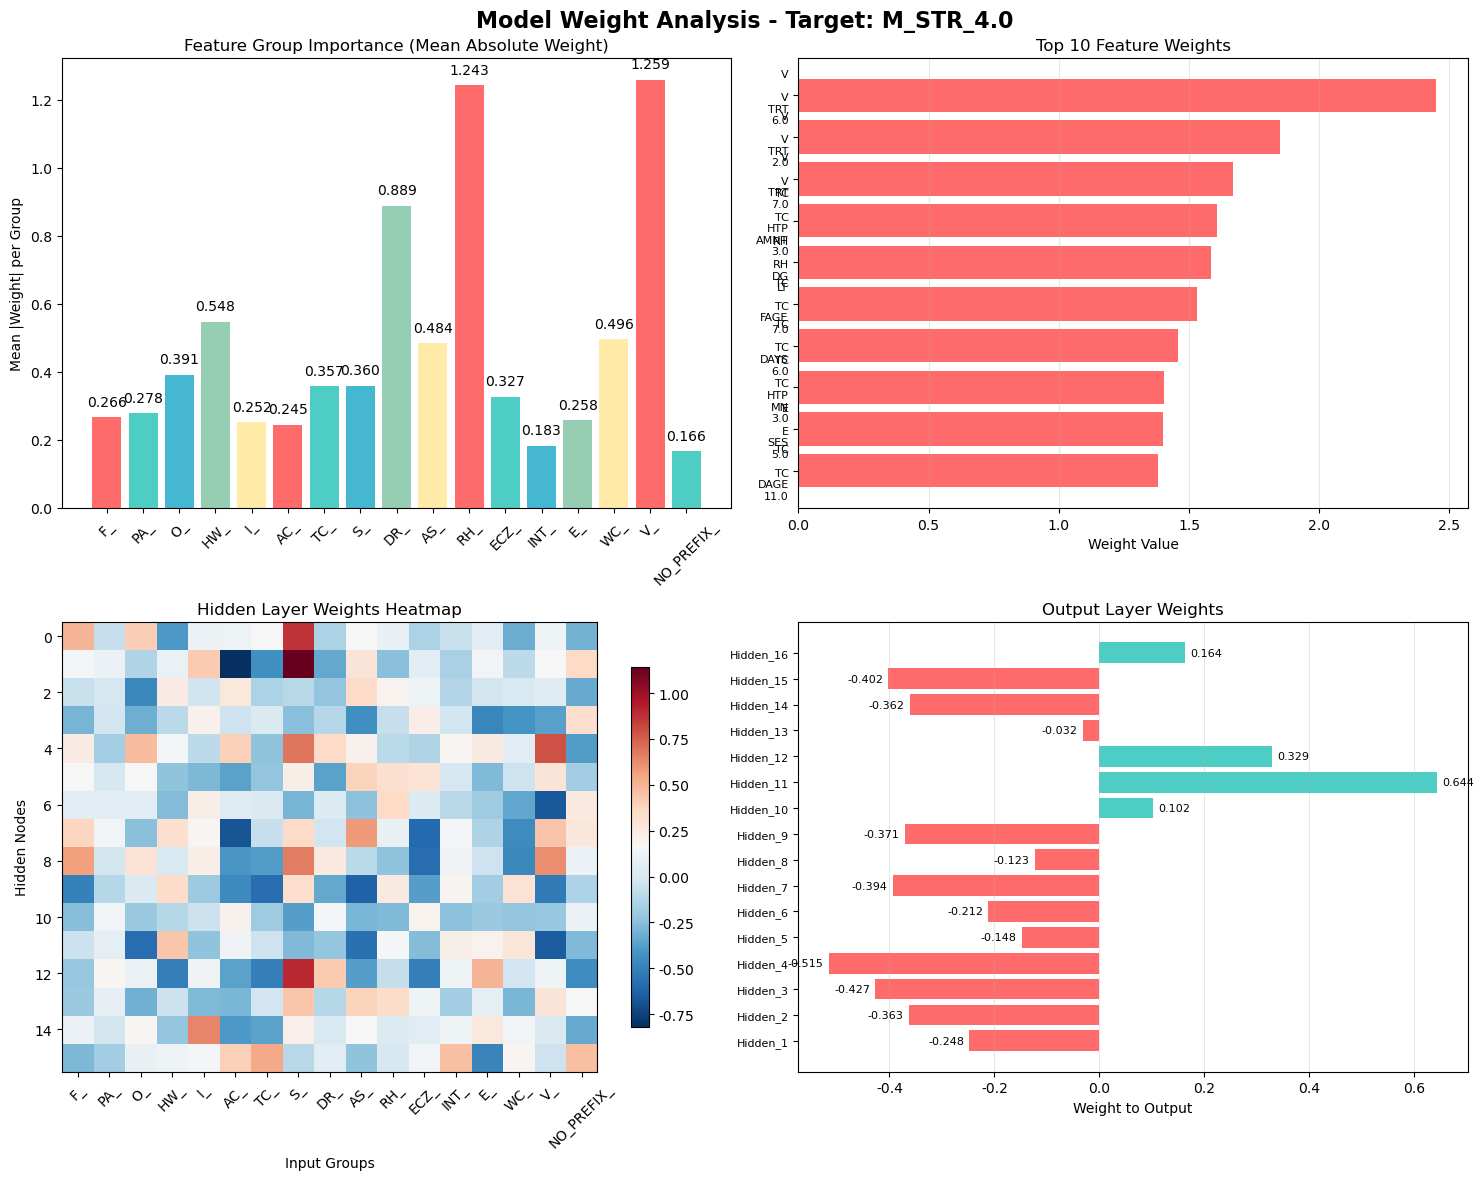

✅ 모델 'M_STR_4.0' 분석 완료!

🚀 모델 학습 시작: Target = M_STR_5.0
🔄 모델 학습 중...
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 8.

📊 학습 결과 요약 - Target: M_STR_5.0
🔄 총 에포크 수: 12
📉 최종 Training Loss: 0.1182
📉 최종 Validation Loss: 0.1244
📈 최종 Training Accuracy: 0.9710
📈 최종 Validation Accuracy: 0.9706
📈 최종 테스트 정확도: 0.9707
📉 최종 테스트 Loss: 0.1237

🎨 가중치 시각화 생성 중...


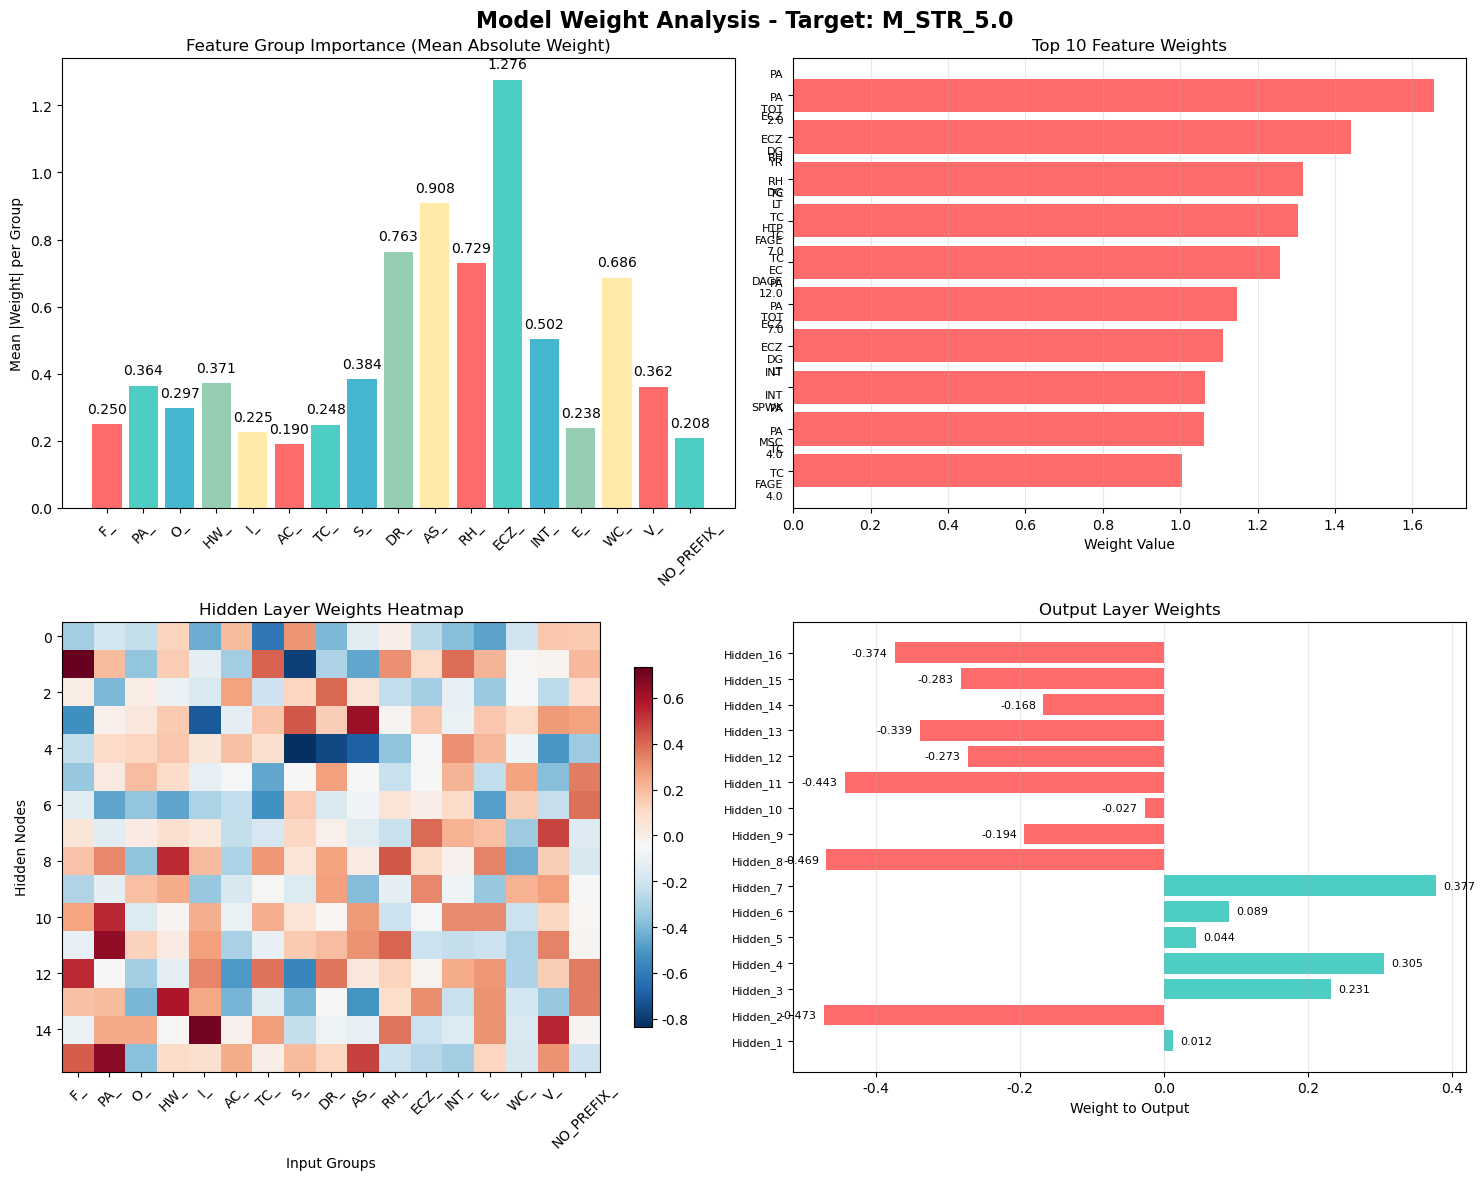

✅ 모델 'M_STR_5.0' 분석 완료!

🎉 전체 학습 완료! 총 5개 모델이 학습되었습니다.


In [18]:
m_targets_4 = ['M_STR_1.0', 'M_STR_2.0', 'M_STR_3.0', 'M_STR_4.0', 'M_STR_5.0']
learning(m_targets_4)


🚀 모델 학습 시작: Target = M_SLP_EN_1.0
🔄 모델 학습 중...
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 4.

📊 학습 결과 요약 - Target: M_SLP_EN_1.0
🔄 총 에포크 수: 8
📉 최종 Training Loss: 0.2282
📉 최종 Validation Loss: 0.2487
📈 최종 Training Accuracy: 0.9320
📈 최종 Validation Accuracy: 0.9274
📈 최종 테스트 정확도: 0.9273
📉 최종 테스트 Loss: 0.2469

🎨 가중치 시각화 생성 중...


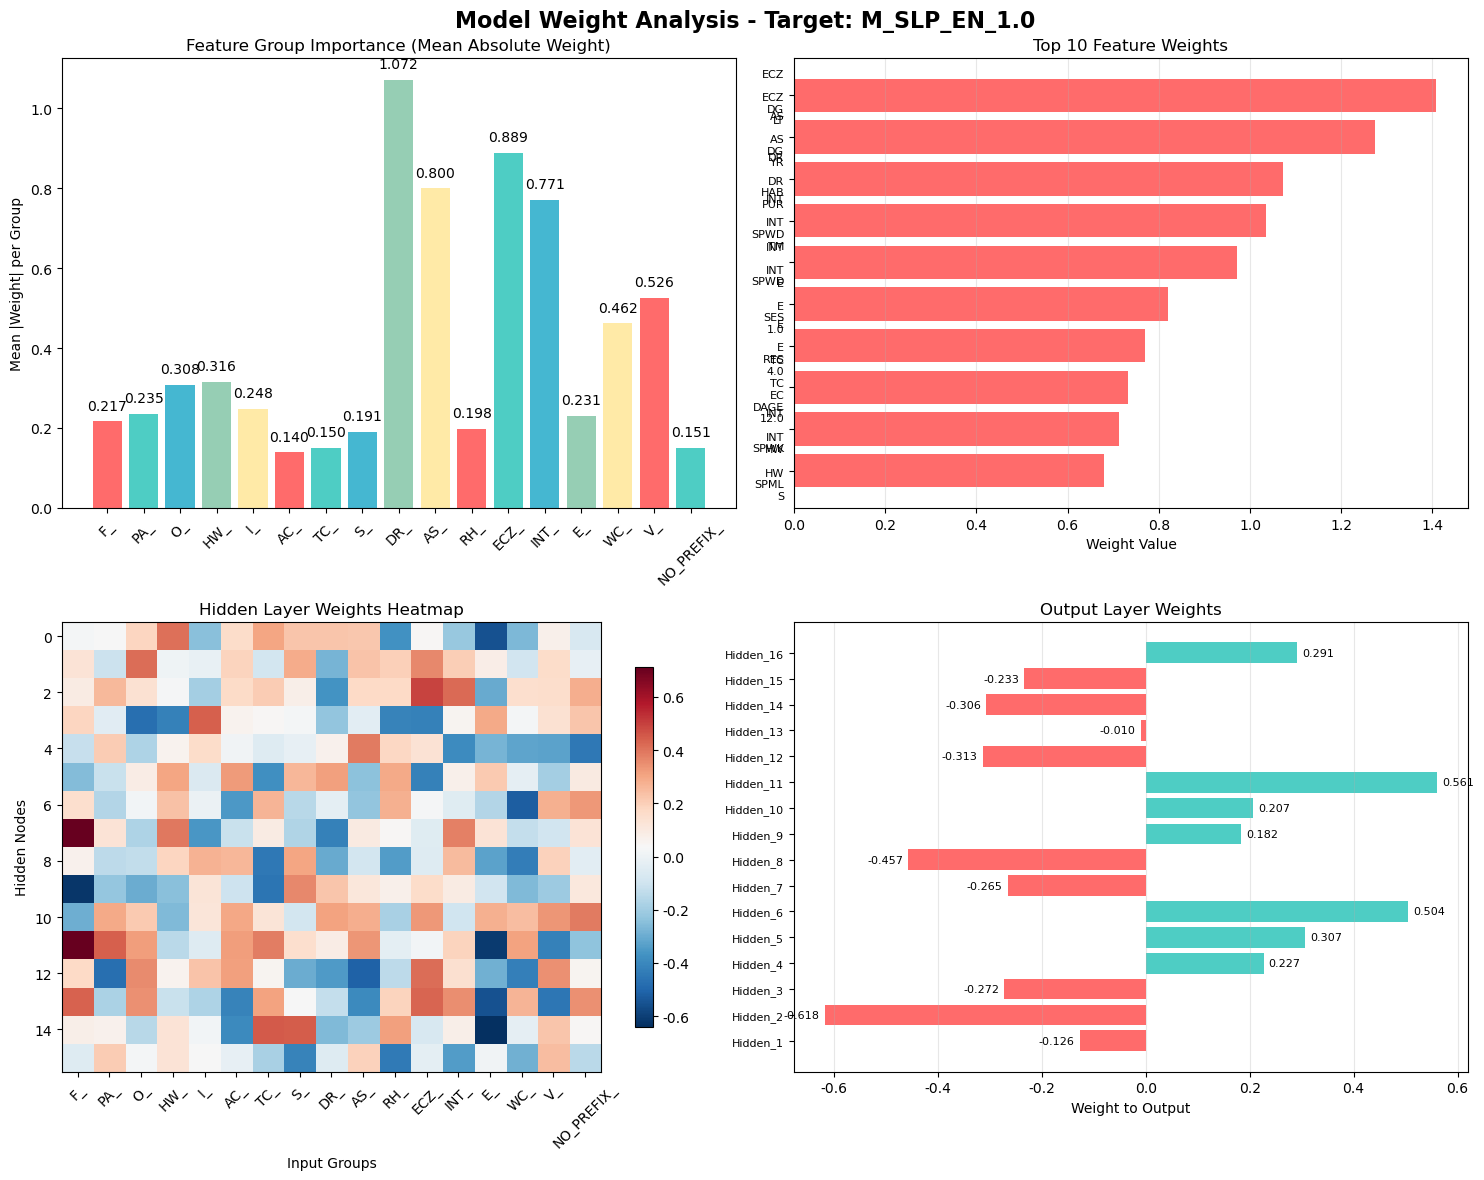

✅ 모델 'M_SLP_EN_1.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_2.0
🔄 모델 학습 중...
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 10.

📊 학습 결과 요약 - Target: M_SLP_EN_2.0
🔄 총 에포크 수: 14
📉 최종 Training Loss: 0.4144
📉 최종 Validation Loss: 0.4135
📈 최종 Training Accuracy: 0.8428
📈 최종 Validation Accuracy: 0.8451
📈 최종 테스트 정확도: 0.8451
📉 최종 테스트 Loss: 0.4132

🎨 가중치 시각화 생성 중...


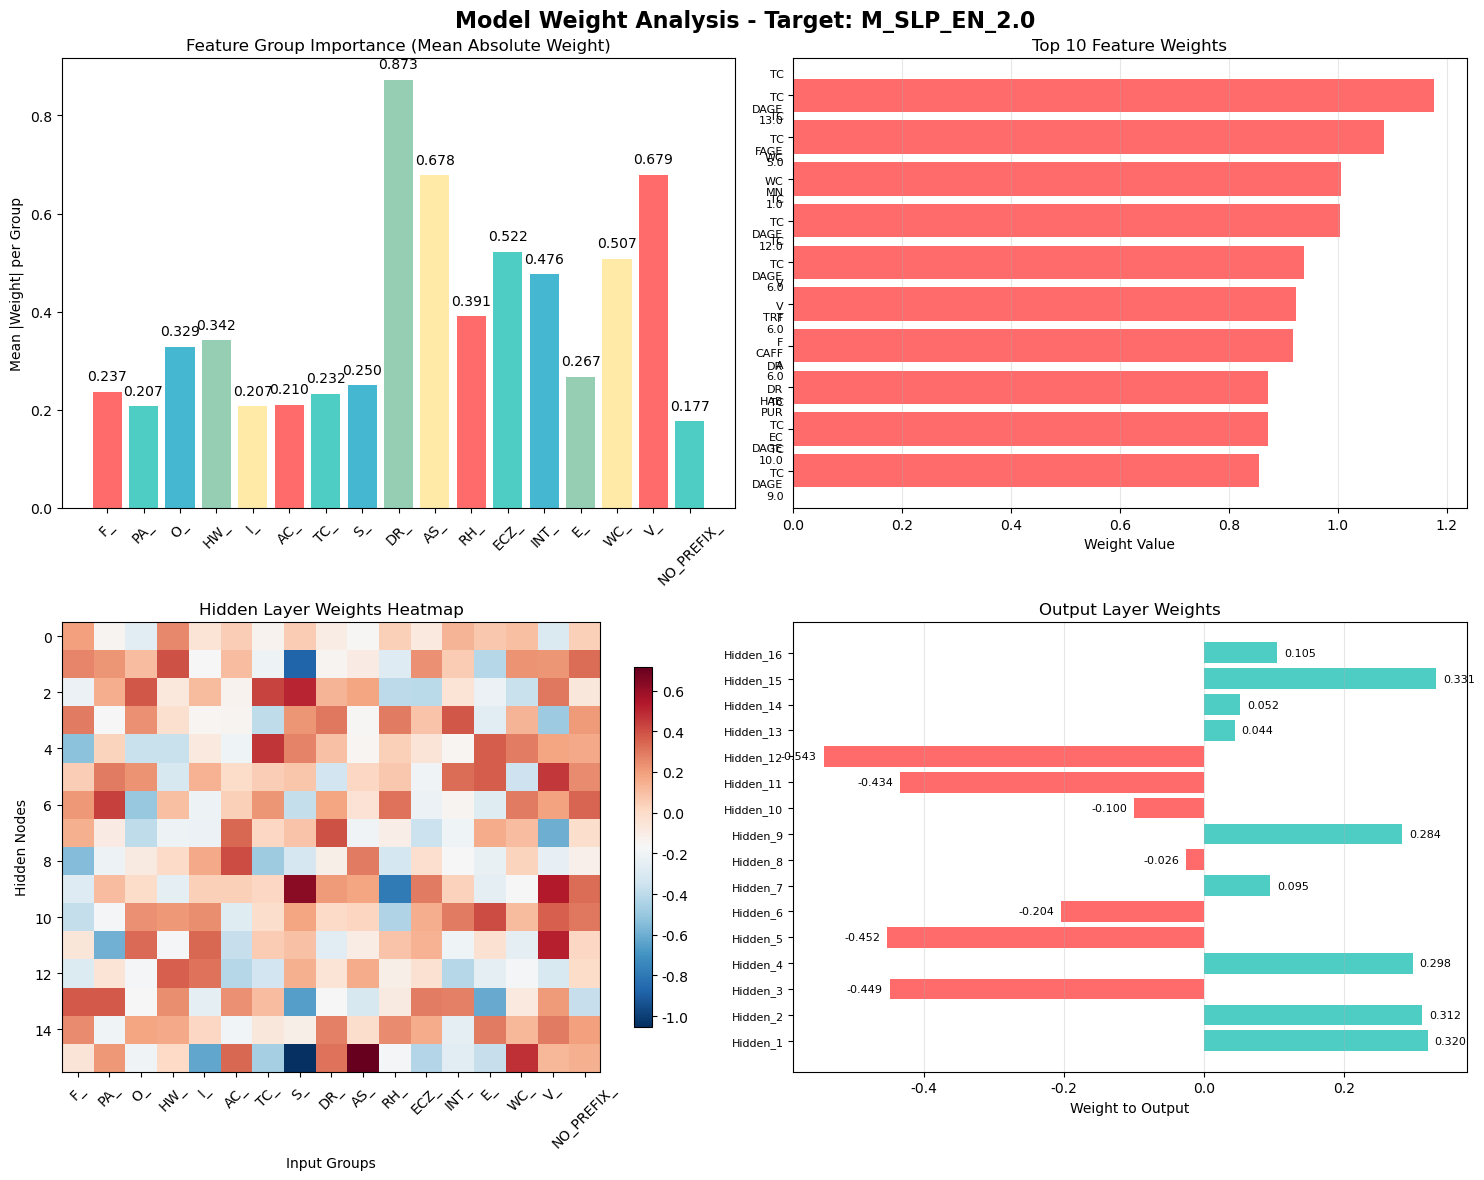

✅ 모델 'M_SLP_EN_2.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_3.0
🔄 모델 학습 중...
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 12.

📊 학습 결과 요약 - Target: M_SLP_EN_3.0
🔄 총 에포크 수: 16
📉 최종 Training Loss: 0.6027
📉 최종 Validation Loss: 0.6036
📈 최종 Training Accuracy: 0.6959
📈 최종 Validation Accuracy: 0.6996
📈 최종 테스트 정확도: 0.7001
📉 최종 테스트 Loss: 0.6029

🎨 가중치 시각화 생성 중...


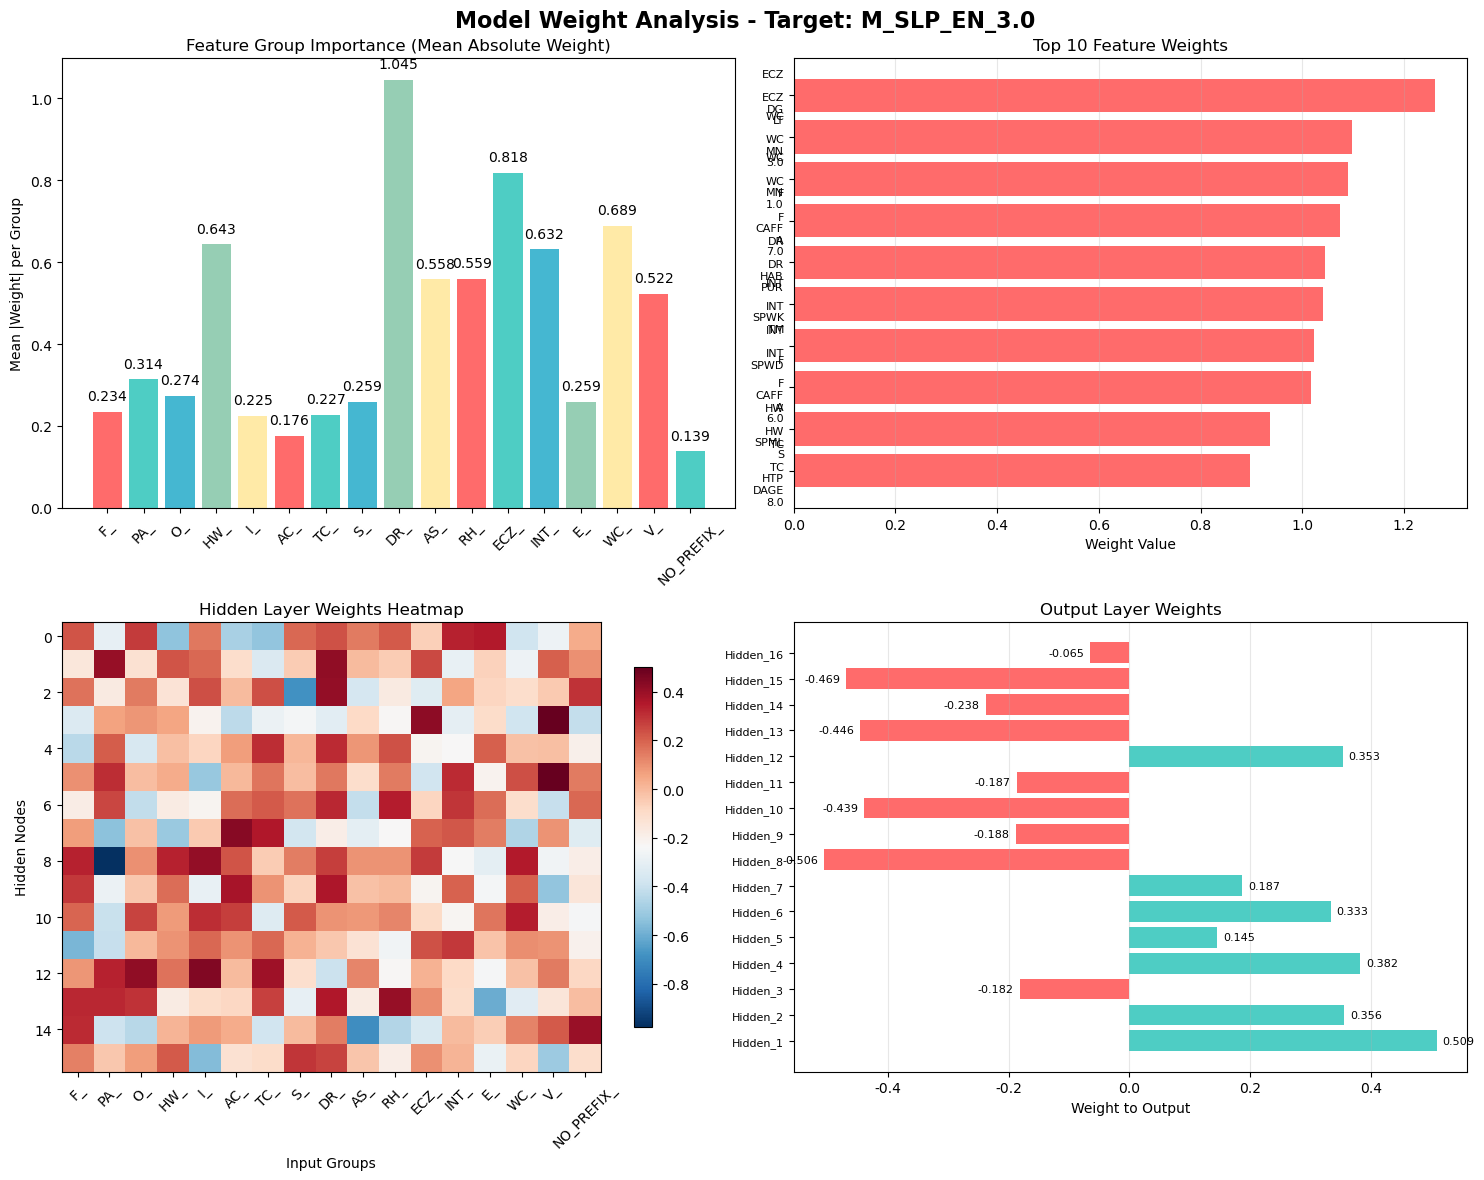

✅ 모델 'M_SLP_EN_3.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_4.0
🔄 모델 학습 중...
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 11.

📊 학습 결과 요약 - Target: M_SLP_EN_4.0
🔄 총 에포크 수: 15
📉 최종 Training Loss: 0.6057
📉 최종 Validation Loss: 0.6179
📈 최종 Training Accuracy: 0.6905
📈 최종 Validation Accuracy: 0.6800
📈 최종 테스트 정확도: 0.6800
📉 최종 테스트 Loss: 0.6175

🎨 가중치 시각화 생성 중...


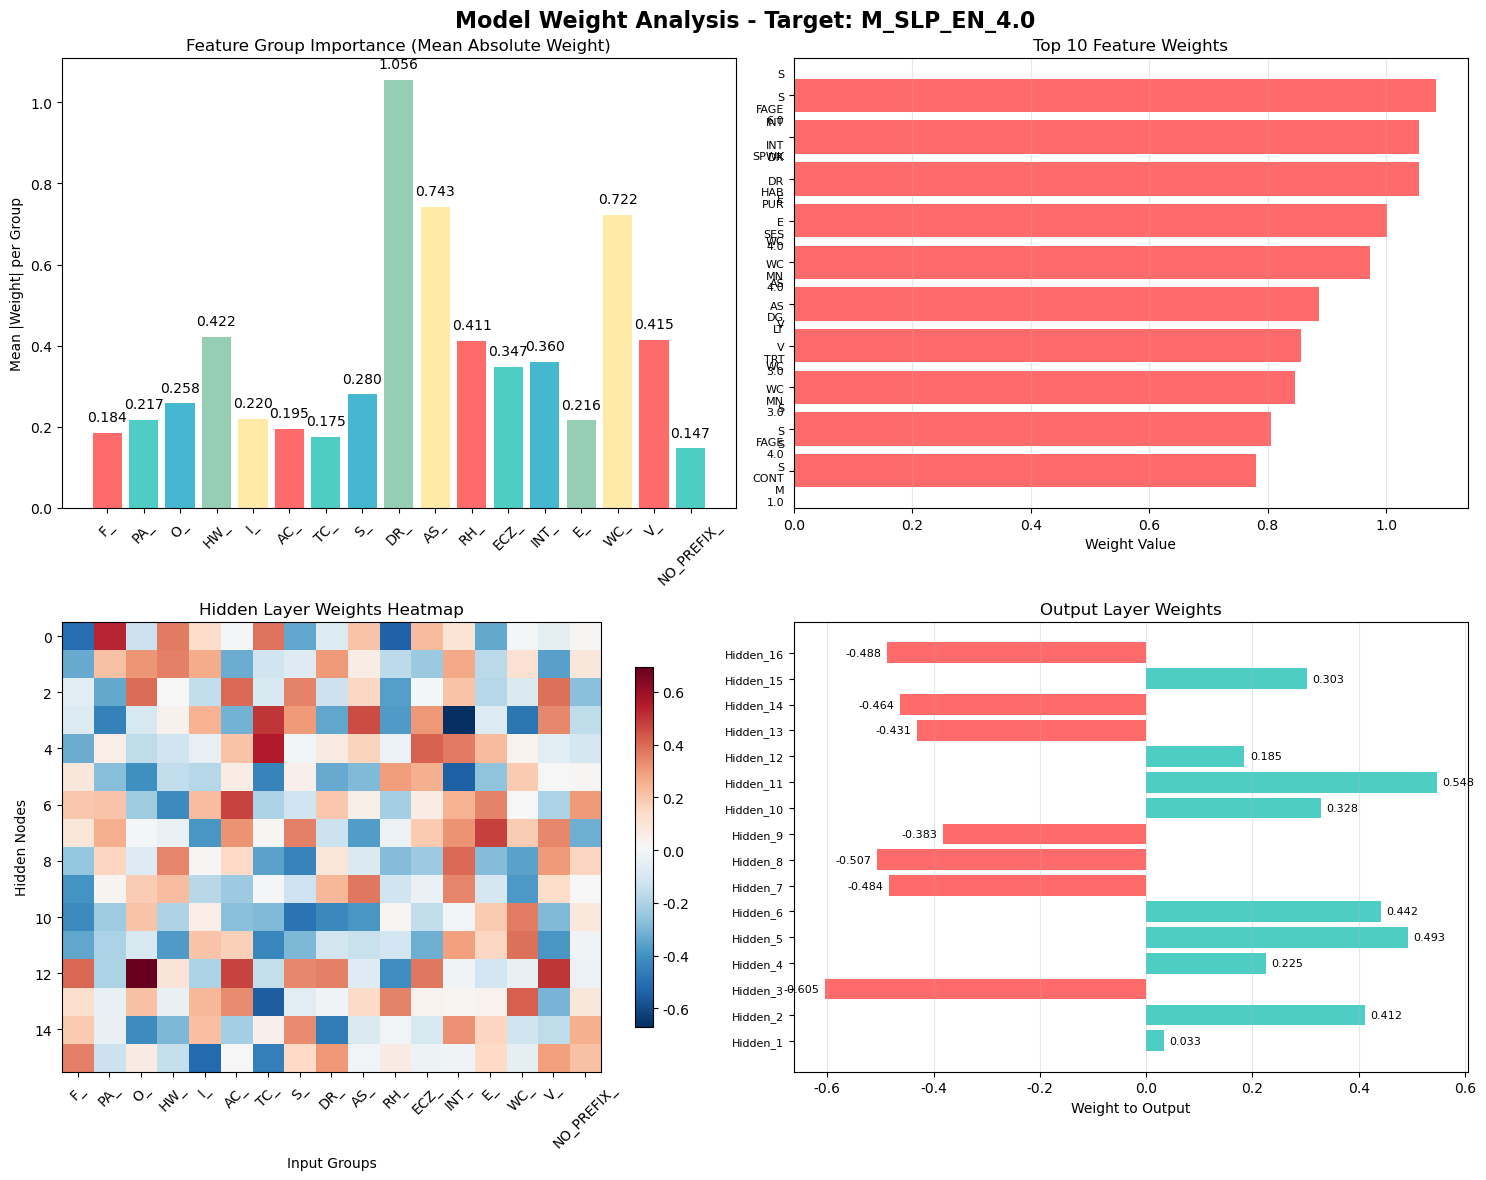

✅ 모델 'M_SLP_EN_4.0' 분석 완료!

🚀 모델 학습 시작: Target = M_SLP_EN_5.0
🔄 모델 학습 중...
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 17.

📊 학습 결과 요약 - Target: M_SLP_EN_5.0
🔄 총 에포크 수: 21
📉 최종 Training Loss: 0.3978
📉 최종 Validation Loss: 0.3963
📈 최종 Training Accuracy: 0.8425
📈 최종 Validation Accuracy: 0.8460
📈 최종 테스트 정확도: 0.8459
📉 최종 테스트 Loss: 0.3947

🎨 가중치 시각화 생성 중...


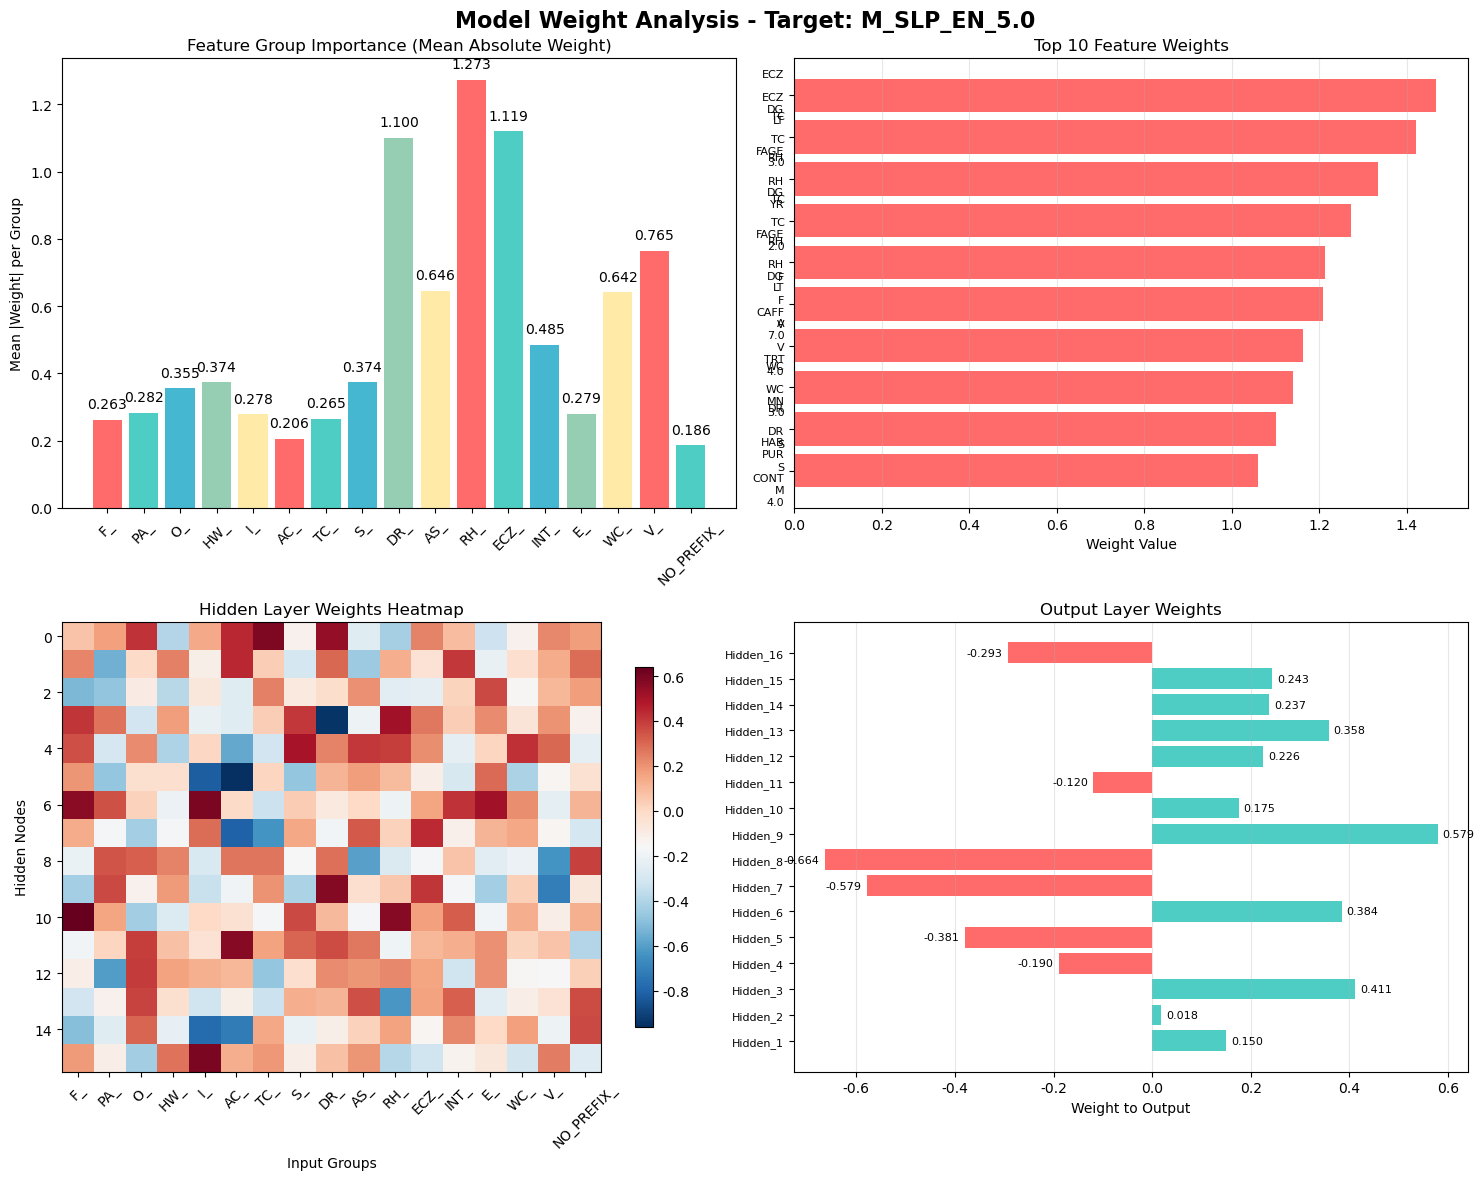

✅ 모델 'M_SLP_EN_5.0' 분석 완료!

🎉 전체 학습 완료! 총 5개 모델이 학습되었습니다.


In [19]:
m_targets_5 = ['M_SLP_EN_1.0', 'M_SLP_EN_2.0', 'M_SLP_EN_3.0', 'M_SLP_EN_4.0', 'M_SLP_EN_5.0']
learning(m_targets_5)


🚀 모델 학습 시작: Target = M_LON_1.0
🔄 모델 학습 중...
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 14.

📊 학습 결과 요약 - Target: M_LON_1.0
🔄 총 에포크 수: 18
📉 최종 Training Loss: 0.4362
📉 최종 Validation Loss: 0.4495
📈 최종 Training Accuracy: 0.8157
📈 최종 Validation Accuracy: 0.8083
📈 최종 테스트 정확도: 0.8073
📉 최종 테스트 Loss: 0.4482

🎨 가중치 시각화 생성 중...


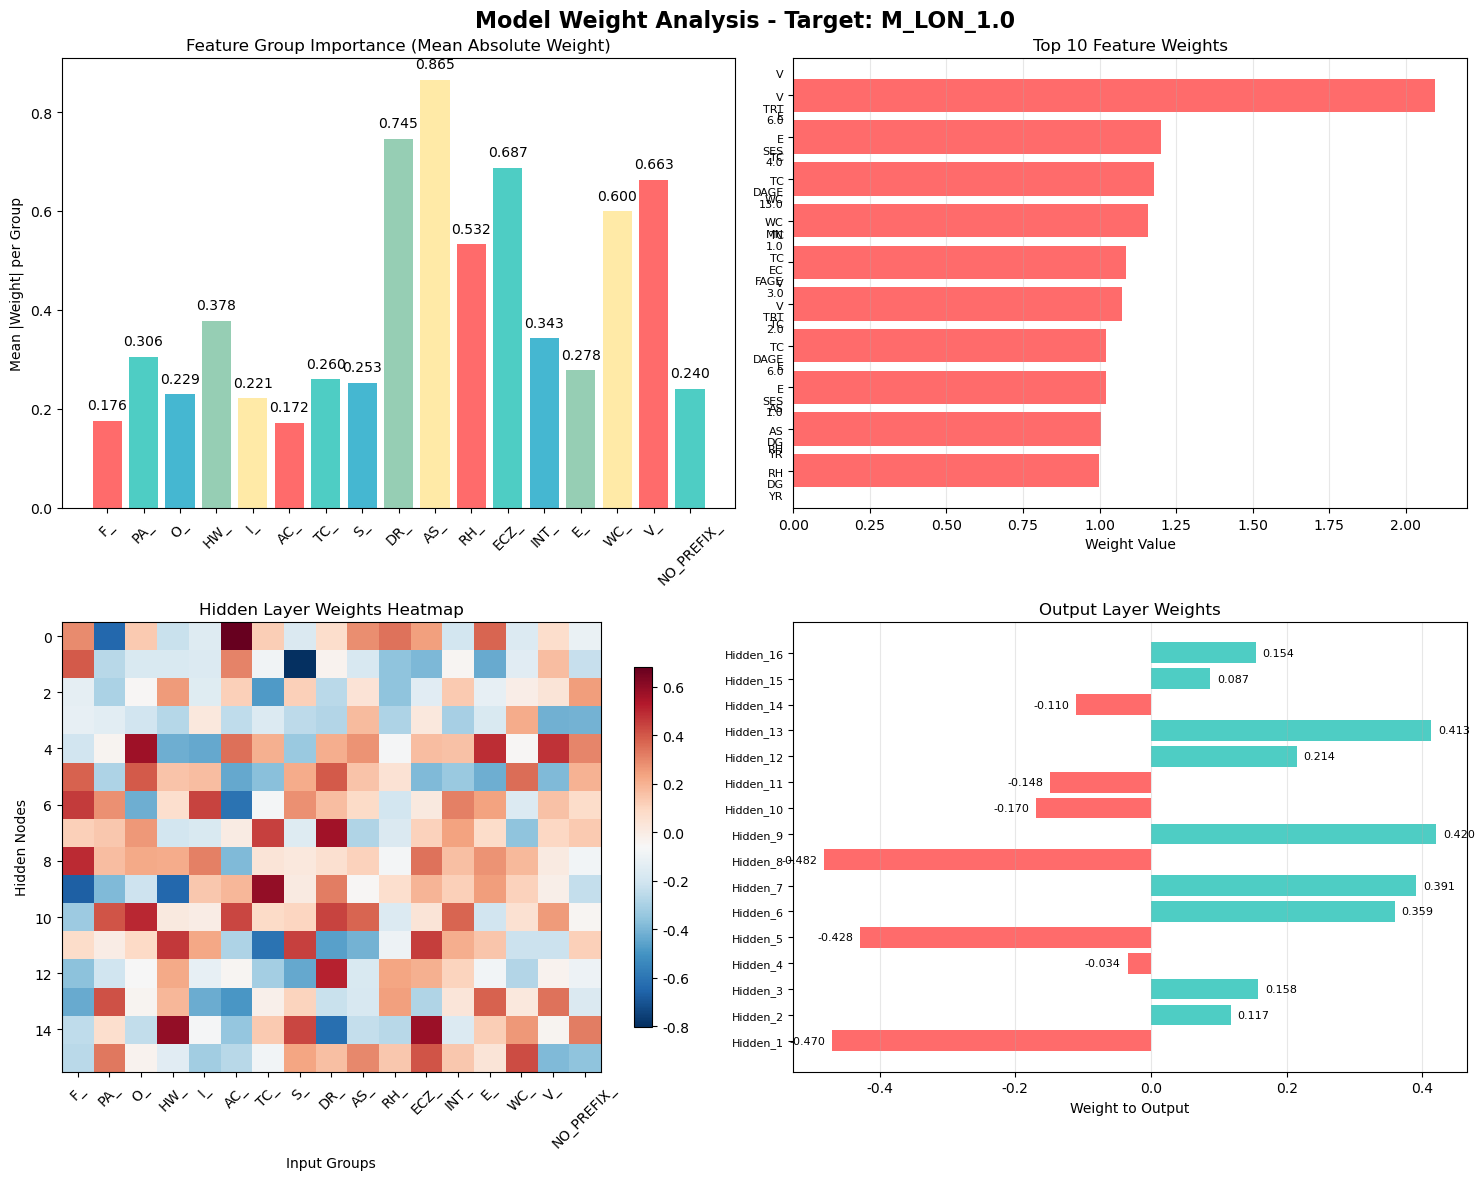

✅ 모델 'M_LON_1.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_2.0
🔄 모델 학습 중...
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 21.

📊 학습 결과 요약 - Target: M_LON_2.0
🔄 총 에포크 수: 25
📉 최종 Training Loss: 0.5567
📉 최종 Validation Loss: 0.5560
📈 최종 Training Accuracy: 0.7427
📈 최종 Validation Accuracy: 0.7451
📈 최종 테스트 정확도: 0.7454
📉 최종 테스트 Loss: 0.5532

🎨 가중치 시각화 생성 중...


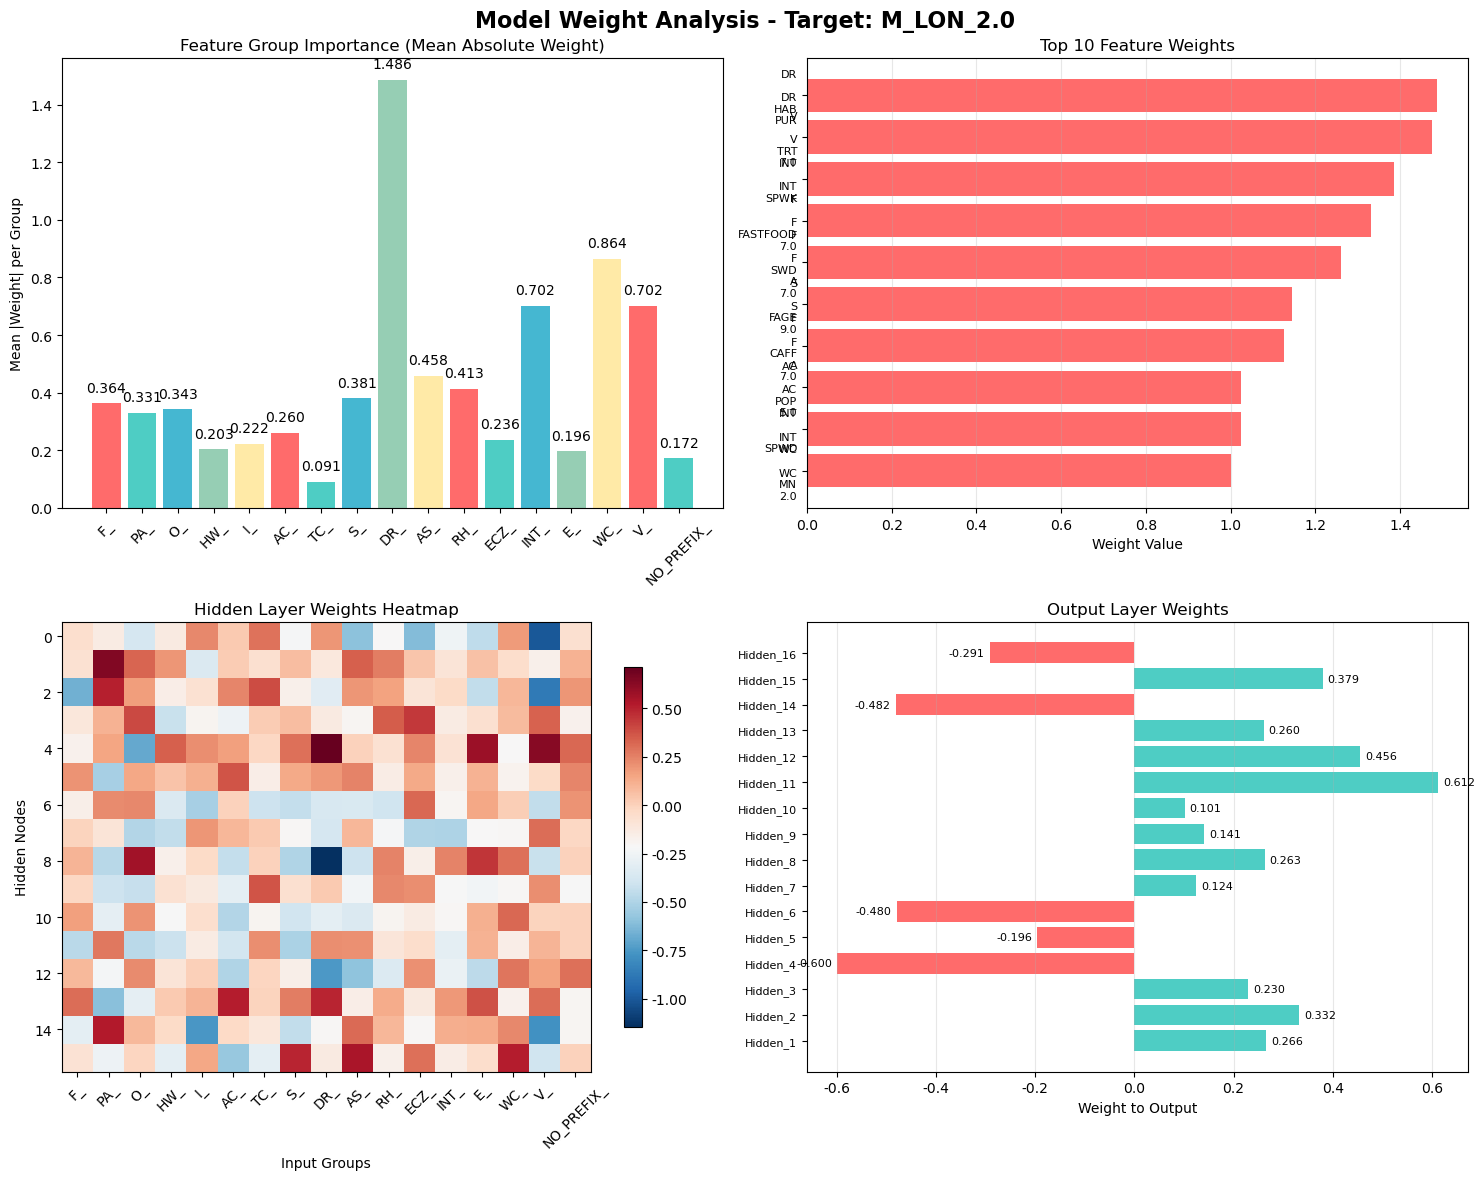

✅ 모델 'M_LON_2.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_3.0
🔄 모델 학습 중...
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 10.

📊 학습 결과 요약 - Target: M_LON_3.0
🔄 총 에포크 수: 14
📉 최종 Training Loss: 0.6453
📉 최종 Validation Loss: 0.6466
📈 최종 Training Accuracy: 0.6333
📈 최종 Validation Accuracy: 0.6331
📈 최종 테스트 정확도: 0.6336
📉 최종 테스트 Loss: 0.6457

🎨 가중치 시각화 생성 중...


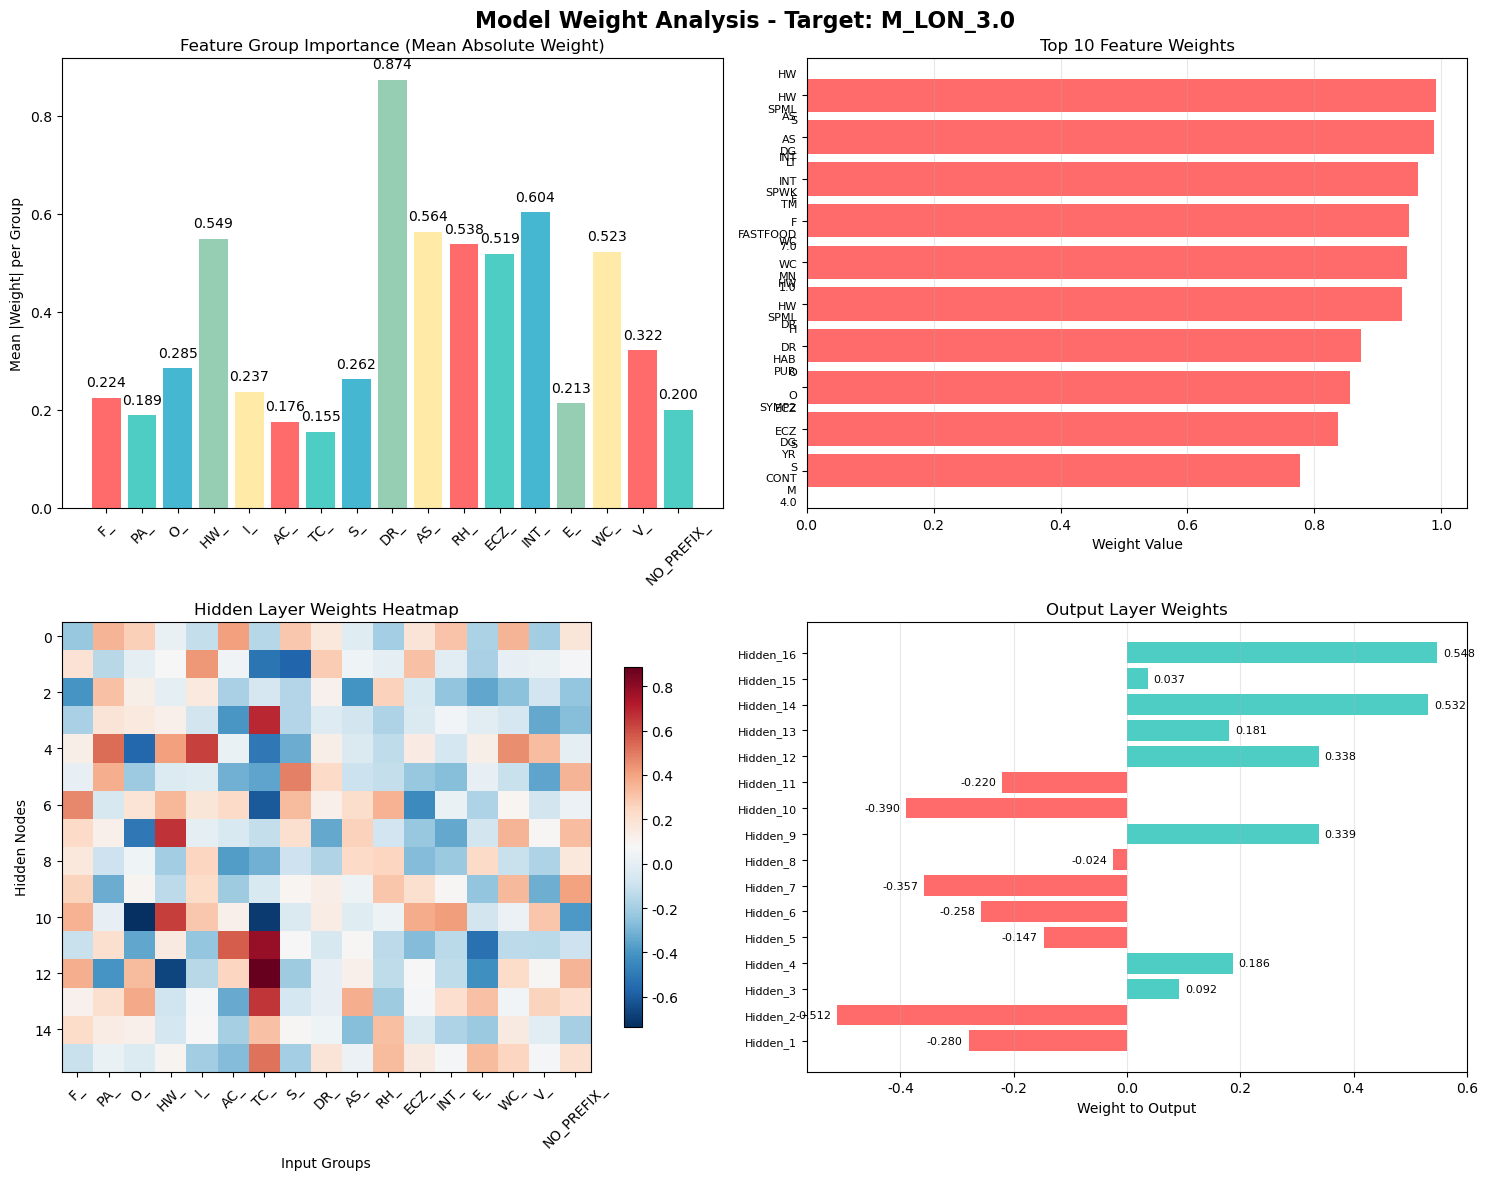

✅ 모델 'M_LON_3.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_4.0
🔄 모델 학습 중...
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 7.

📊 학습 결과 요약 - Target: M_LON_4.0
🔄 총 에포크 수: 11
📉 최종 Training Loss: 0.3951
📉 최종 Validation Loss: 0.3996
📈 최종 Training Accuracy: 0.8538
📈 최종 Validation Accuracy: 0.8544
📈 최종 테스트 정확도: 0.8540
📉 최종 테스트 Loss: 0.3993

🎨 가중치 시각화 생성 중...


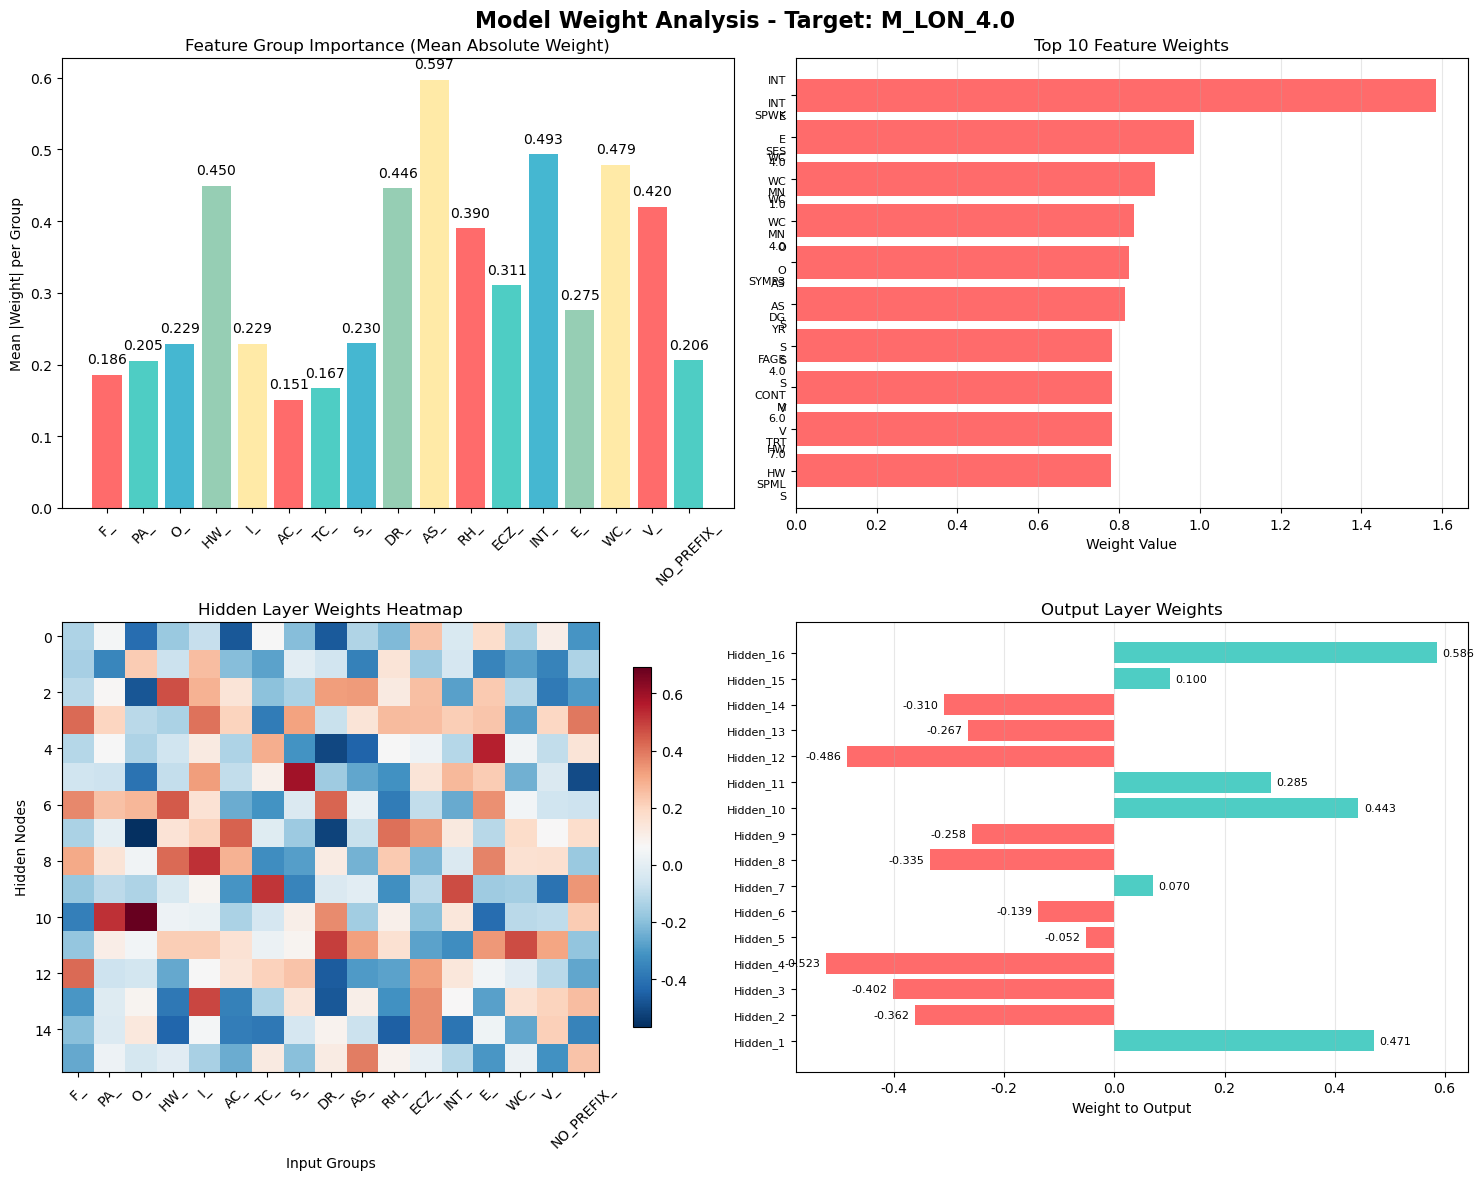

✅ 모델 'M_LON_4.0' 분석 완료!

🚀 모델 학습 시작: Target = M_LON_5.0
🔄 모델 학습 중...
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 7.

📊 학습 결과 요약 - Target: M_LON_5.0
🔄 총 에포크 수: 11
📉 최종 Training Loss: 0.1502
📉 최종 Validation Loss: 0.1567
📈 최종 Training Accuracy: 0.9603
📈 최종 Validation Accuracy: 0.9602
📈 최종 테스트 정확도: 0.9604
📉 최종 테스트 Loss: 0.1538

🎨 가중치 시각화 생성 중...


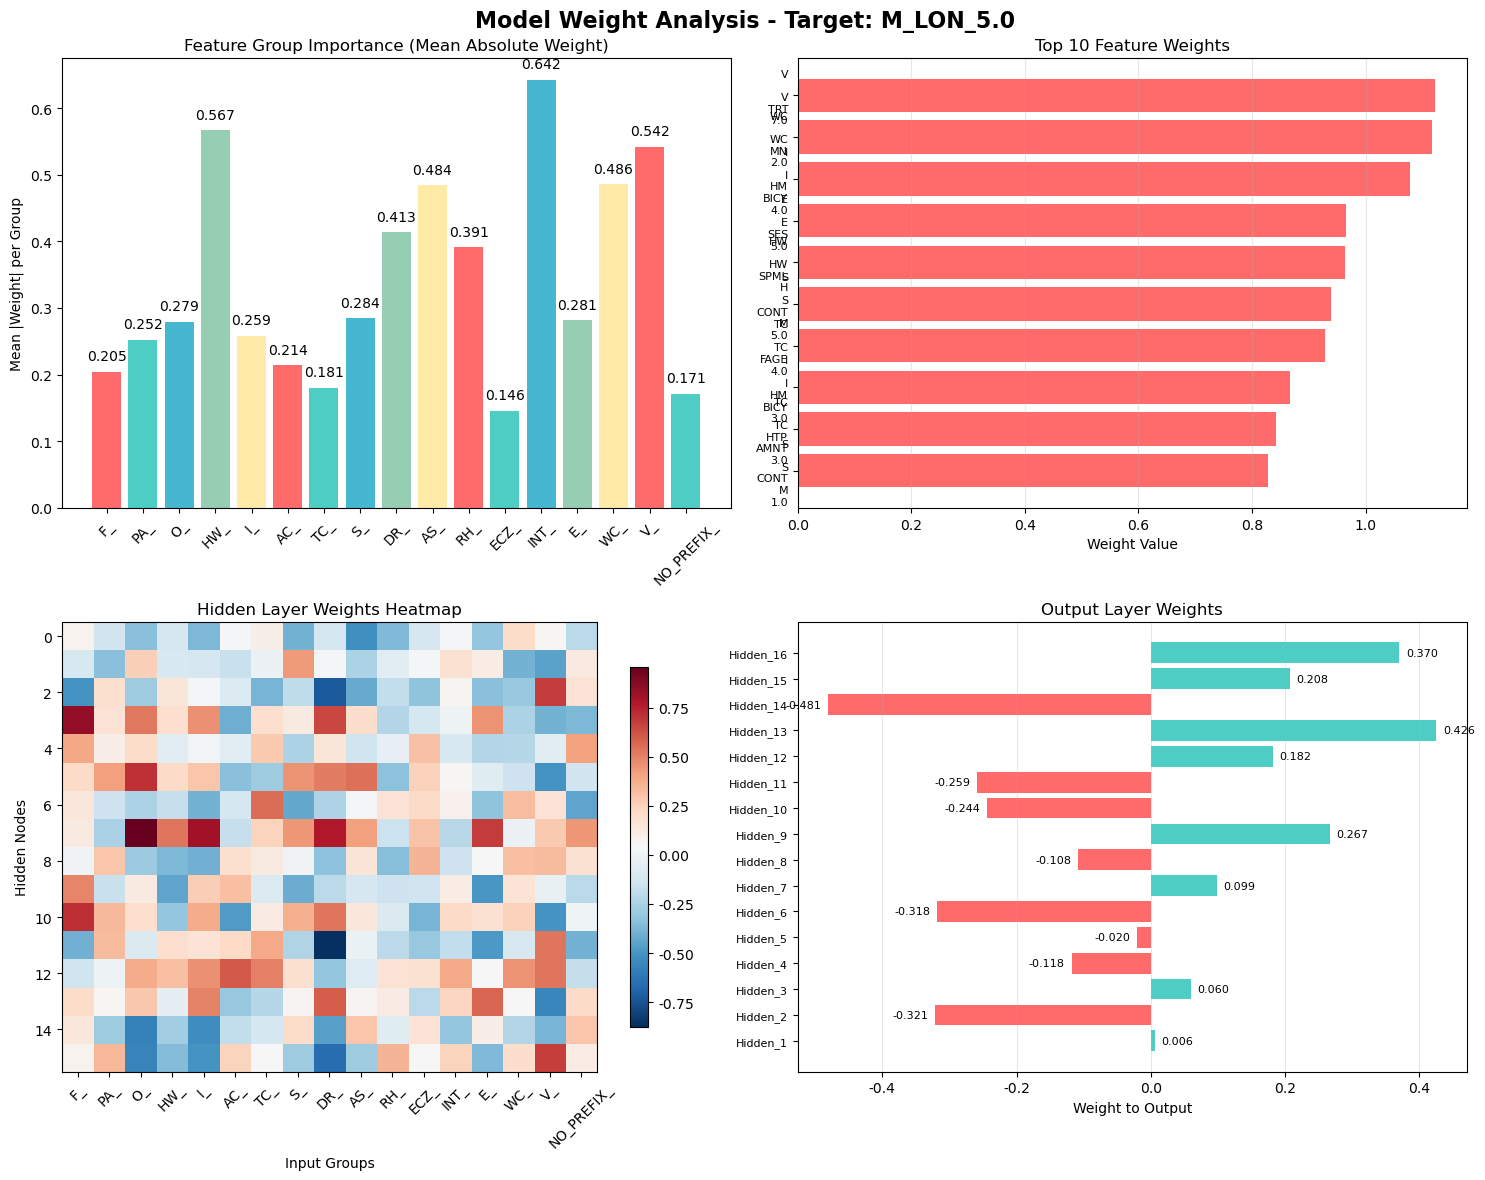

✅ 모델 'M_LON_5.0' 분석 완료!

🎉 전체 학습 완료! 총 5개 모델이 학습되었습니다.


In [20]:
m_targets_6 = ['M_LON_1.0', 'M_LON_2.0', 'M_LON_3.0', 'M_LON_4.0', 'M_LON_5.0']
learning(m_targets_6)